In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
from mlxtend.preprocessing import TransactionEncoder

%matplotlib inline
plt.style.use('fivethirtyeight')
sns.set_style('whitegrid')

In [3]:
items = pd.read_csv('C:/Users/Radwa/Documents/items.csv',sep='|')
orders = pd.read_csv('C:/Users/Radwa/Documents/orders.csv',sep='|')

In [4]:
items.head()

,itemID,brand,manufacturer,customerRating,category1,category2,category3,recommendedRetailPrice
0,1,0,1,4.38,1,1,1,8.84
1,2,0,2,3.00,1,2,1,16.92
2,3,0,3,5.00,1,3,1,15.89
3,4,0,2,4.44,1,2,1,40.17
4,5,0,2,2.33,1,1,1,17.04


In [5]:
orders.head()

,time,transactID,itemID,order,salesPrice
0,2018-01-01 00:01:56,2278968,450,1,17.42
1,2018-01-01 00:01:56,2278968,83,1,5.19
2,2018-01-01 00:07:11,2255797,7851,2,20.47
3,2018-01-01 00:09:24,2278968,450,1,17.42
4,2018-01-01 00:09:24,2278968,83,1,5.19


In [6]:
len(orders)

2181955

In [7]:
len(items)

10463

## Exploratory Data Analysis (EDA)

In [8]:
items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10463 entries, 0 to 10462
Data columns (total 8 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   itemID                  10463 non-null  int64  
 1   brand                   10463 non-null  int64  
 2   manufacturer            10463 non-null  int64  
 3   customerRating          10463 non-null  float64
 4   category1               10463 non-null  int64  
 5   category2               10463 non-null  int64  
 6   category3               10463 non-null  int64  
 7   recommendedRetailPrice  10463 non-null  float64
dtypes: float64(2), int64(6)
memory usage: 654.1 KB


In [9]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2181955 entries, 0 to 2181954
Data columns (total 5 columns):
 #   Column      Dtype  
---  ------      -----  
 0   time        object 
 1   transactID  int64  
 2   itemID      int64  
 3   order       int64  
 4   salesPrice  float64
dtypes: float64(1), int64(3), object(1)
memory usage: 83.2+ MB


In [10]:
items.isnull().sum()

itemID                    0
brand                     0
manufacturer              0
customerRating            0
category1                 0
category2                 0
category3                 0
recommendedRetailPrice    0
dtype: int64

In [11]:
orders.isnull().sum()

time          0
transactID    0
itemID        0
order         0
salesPrice    0
dtype: int64

In [12]:
orders['itemID'].nunique()

9840

In [13]:
items['itemID'].count()

10463

In [14]:
corr= items.corr()
corr

,itemID,brand,manufacturer,customerRating,category1,category2,category3,recommendedRetailPrice
itemID,1.000000,0.698318,0.892386,-0.001112,0.858874,0.932441,0.962452,0.151178
brand,0.698318,1.000000,0.675644,0.011646,0.615523,0.692522,0.714801,0.233218
manufacturer,0.892386,0.675644,1.000000,-0.029951,0.770533,0.868943,0.845808,0.152874
customerRating,-0.001112,0.011646,-0.029951,1.000000,-0.003676,0.016965,0.049804,-0.043440
category1,0.858874,0.615523,0.770533,-0.003676,1.000000,0.831421,0.862967,0.137688
category2,0.932441,0.692522,0.868943,0.016965,0.831421,1.000000,0.928835,0.156701
category3,0.962452,0.714801,0.845808,0.049804,0.862967,0.928835,1.000000,0.165201
recommendedRetailPrice,0.151178,0.233218,0.152874,-0.043440,0.137688,0.156701,0.165201,1.000000


## Data Preparations

In [15]:
# change time datatype to date only
orders['time']=pd.to_datetime(orders['time']).dt.date

In [16]:
orders.head()

,time,transactID,itemID,order,salesPrice
0,2018-01-01,2278968,450,1,17.42
1,2018-01-01,2278968,83,1,5.19
2,2018-01-01,2255797,7851,2,20.47
3,2018-01-01,2278968,450,1,17.42
4,2018-01-01,2278968,83,1,5.19


In [17]:
#however time now contains date but in type object
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2181955 entries, 0 to 2181954
Data columns (total 5 columns):
 #   Column      Dtype  
---  ------      -----  
 0   time        object 
 1   transactID  int64  
 2   itemID      int64  
 3   order       int64  
 4   salesPrice  float64
dtypes: float64(1), int64(3), object(1)
memory usage: 83.2+ MB


In [18]:
orders['time']=pd.to_datetime(orders['time'], format='%Y-%m-%d')

In [19]:
#now time is in datetime type
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2181955 entries, 0 to 2181954
Data columns (total 5 columns):
 #   Column      Dtype         
---  ------      -----         
 0   time        datetime64[ns]
 1   transactID  int64         
 2   itemID      int64         
 3   order       int64         
 4   salesPrice  float64       
dtypes: datetime64[ns](1), float64(1), int64(3)
memory usage: 83.2 MB


In [20]:
# we drop the columns that doesn't mean to our data in items data set
items= items.drop(columns=['category1','category2','category3'])

In [21]:
# we will get the daily demand of orders
daily_demand=orders.groupby(['itemID', 'time'])
daily_demand.head()

,time,transactID,itemID,order,salesPrice
0,2018-01-01,2278968,450,1,17.42
1,2018-01-01,2278968,83,1,5.19
2,2018-01-01,2255797,7851,2,20.47
3,2018-01-01,2278968,450,1,17.42
4,2018-01-01,2278968,83,1,5.19
...,...,...,...,...,...
2181927,2018-06-29,2040326,9217,1,23.50
2181928,2018-06-29,2040325,9217,1,23.50
2181929,2018-06-29,2040327,9217,1,23.50
2181951,2018-06-29,2260943,2175,1,11.60


In [22]:
daily_demand=daily_demand.agg({'order': 'sum', 'salesPrice': 'sum'})
daily_demand.head()

order  salesPrice
itemID time                         
1      2018-01-23      1        3.11
       2018-01-25      1        3.11
       2018-01-29    307      789.94
       2018-01-30      3        9.33
       2018-01-31      1        3.11

In [23]:
# we will do reset index to make time and itemid be columns
daily_demand=daily_demand.reset_index()
daily_demand

,itemID,time,order,salesPrice
0,1,2018-01-23,1,3.11
1,1,2018-01-25,1,3.11
2,1,2018-01-29,307,789.94
3,1,2018-01-30,3,9.33
4,1,2018-01-31,1,3.11
...,...,...,...,...
100143,10450,2018-06-29,2,88.96
100144,10459,2018-05-05,1,14.71
100145,10460,2018-04-16,1,325.67
100146,10462,2018-04-22,1,304.30


In [24]:
# we will merge daily demand with items data set
df_merged=pd.merge(daily_demand, items, on='itemID',how='inner')
df_merged.sort_values('time', inplace=True)
df_merged.head(10)

,itemID,time,order,salesPrice,brand,manufacturer,customerRating,recommendedRetailPrice
51485,5032,2018-01-01,1,237.92,0,100,5.00,96.87
83031,8118,2018-01-01,1,8.62,0,70,3.67,12.24
16847,1968,2018-01-01,1,9.27,10,43,5.00,38.98
83168,8124,2018-01-01,1,4.35,116,121,5.00,7.52
1234,113,2018-01-01,81,215.46,0,8,0.00,7.85
63106,6495,2018-01-01,1,67.22,93,137,5.00,48.00
76572,7844,2018-01-01,1,4.08,120,210,5.00,6.23
92804,8992,2018-01-01,1,27.32,187,234,0.00,50.93
6992,622,2018-01-01,31,4296.30,0,17,0.00,140.39
95619,9348,2018-01-01,1,44.54,182,227,3.00,45.44


In [25]:
# we will make time as index for df_merged
df_merged = df_merged.set_index('time')


In [26]:
df_merged.head(10)

,itemID,order,salesPrice,brand,manufacturer,customerRating,recommendedRetailPrice
time,,,,,,,
2018-01-01,5032,1,237.92,0,100,5.00,96.87
2018-01-01,8118,1,8.62,0,70,3.67,12.24
2018-01-01,1968,1,9.27,10,43,5.00,38.98
2018-01-01,8124,1,4.35,116,121,5.00,7.52
2018-01-01,113,81,215.46,0,8,0.00,7.85
2018-01-01,6495,1,67.22,93,137,5.00,48.00
2018-01-01,7844,1,4.08,120,210,5.00,6.23
2018-01-01,8992,1,27.32,187,234,0.00,50.93
2018-01-01,622,31,4296.30,0,17,0.00,140.39


In [27]:
#make sure it is dattime index
df_merged.index

DatetimeIndex(['2018-01-01', '2018-01-01', '2018-01-01', '2018-01-01',
               '2018-01-01', '2018-01-01', '2018-01-01', '2018-01-01',
               '2018-01-01', '2018-01-01',
               ...
               '2018-06-29', '2018-06-29', '2018-06-29', '2018-06-29',
               '2018-06-29', '2018-06-29', '2018-06-29', '2018-06-29',
               '2018-06-29', '2018-06-29'],
              dtype='datetime64[ns]', name='time', length=100148, freq=None)

In [28]:
df_Jan_train= df_merged.loc["2018-01-01":"2018-01-21"]
df_Jan_train

,itemID,order,salesPrice,brand,manufacturer,customerRating,recommendedRetailPrice
time,,,,,,,
2018-01-01,5032,1,237.92,0,100,5.00,96.87
2018-01-01,8118,1,8.62,0,70,3.67,12.24
2018-01-01,1968,1,9.27,10,43,5.00,38.98
2018-01-01,8124,1,4.35,116,121,5.00,7.52
2018-01-01,113,81,215.46,0,8,0.00,7.85
...,...,...,...,...,...,...,...
2018-01-21,8175,1,8.49,115,204,5.00,7.82
2018-01-21,9167,46,2509.74,0,226,5.00,36.19
2018-01-21,5130,108,3625.58,92,80,4.71,17.76


In [29]:
df_Jan_test= df_merged.loc["2018-01-22":"2018-01-31"]
df_Jan_test

,itemID,order,salesPrice,brand,manufacturer,customerRating,recommendedRetailPrice
time,,,,,,,
2018-01-22,7917,109,1682.70,118,207,5.00,21.09
2018-01-22,4212,243,2718.60,80,93,3.00,8.69
2018-01-22,262,1,17.25,0,2,1.00,27.75
2018-01-22,4250,9,186.84,80,93,0.00,12.80
2018-01-22,4895,2,1.36,0,66,2.93,5.45
...,...,...,...,...,...,...,...
2018-01-31,4874,1,10.23,0,51,2.06,11.29
2018-01-31,7838,15,103.23,120,210,4.40,11.44
2018-01-31,615,1,4.51,0,4,0.00,14.26


In [30]:
df_Feb_train= df_merged.loc["2018-02-01":"2018-02-18"]
df_Feb_train

,itemID,order,salesPrice,brand,manufacturer,customerRating,recommendedRetailPrice
time,,,,,,,
2018-02-01,9260,1,229.98,0,239,4.0,65.55
2018-02-01,6940,1,7.12,0,137,0.0,11.12
2018-02-01,8908,1,299.00,190,237,0.0,299.90
2018-02-01,4359,2,14.64,0,61,1.0,7.04
2018-02-01,5411,1,11.07,0,160,5.0,10.36
...,...,...,...,...,...,...,...
2018-02-18,4331,1,1.32,0,100,0.0,4.03
2018-02-18,5022,1,13.46,82,96,4.5,6.90
2018-02-18,8022,1,11.98,118,207,4.2,12.65


In [31]:
df_Feb_test= df_merged.loc["2018-02-19":"2018-02-28"]
df_Feb_test

,itemID,order,salesPrice,brand,manufacturer,customerRating,recommendedRetailPrice
time,,,,,,,
2018-02-19,2518,1,35.06,21,23,0.00,19.82
2018-02-19,6851,318,11752.70,0,178,5.00,21.75
2018-02-19,4994,1,10.02,0,45,3.14,8.22
2018-02-19,8035,1,18.43,113,202,0.00,13.41
2018-02-19,6891,202,2314.99,93,172,5.00,14.79
...,...,...,...,...,...,...,...
2018-02-28,3208,6,126.90,70,84,0.00,19.67
2018-02-28,5549,5,68.72,0,159,0.00,13.45
2018-02-28,9519,3,1036.92,196,235,3.00,500.31


In [32]:
df_Mar_train= df_merged.loc["2018-03-01":"2018-03-21"]
df_Mar_train

,itemID,order,salesPrice,brand,manufacturer,customerRating,recommendedRetailPrice
time,,,,,,,
2018-03-01,8461,454,2311.28,116,121,0.00,12.89
2018-03-01,7871,2,12.49,116,121,5.00,27.38
2018-03-01,3216,117,322.00,0,85,0.00,10.35
2018-03-01,3240,165,603.52,0,85,0.00,11.34
2018-03-01,3241,67,1419.00,0,85,0.00,16.84
...,...,...,...,...,...,...,...
2018-03-21,7761,9,12.40,112,128,4.58,9.15
2018-03-21,4483,2,6.92,0,61,3.50,6.50
2018-03-21,1858,1,12.66,7,42,4.67,18.90


In [33]:
df_Mar_test= df_merged.loc["2018-03-22":"2018-03-31"]
df_Mar_test

,itemID,order,salesPrice,brand,manufacturer,customerRating,recommendedRetailPrice
time,,,,,,,
2018-03-22,5092,1,74.14,88,51,5.0,62.28
2018-03-22,8403,10,15.82,116,121,5.0,7.33
2018-03-22,573,107,606.32,0,11,0.0,17.34
2018-03-22,8263,1,13.92,126,121,1.0,19.69
2018-03-22,273,1,15.89,0,11,5.0,28.35
...,...,...,...,...,...,...,...
2018-03-31,3234,1,32.73,0,85,5.0,19.37
2018-03-31,3177,86,886.14,68,83,0.0,55.77
2018-03-31,8081,1,3.26,117,205,0.0,7.61


In [34]:
df_Apr_train= df_merged.loc["2018-04-01":"2018-04-20"]
df_Apr_train

,itemID,order,salesPrice,brand,manufacturer,customerRating,recommendedRetailPrice
time,,,,,,,
2018-04-01,3192,1,24.37,66,82,0.0,25.38
2018-04-01,2412,1,81.35,41,65,4.0,67.09
2018-04-01,4258,1,3.66,0,102,0.0,9.28
2018-04-01,8278,2,3.28,0,213,5.0,5.38
2018-04-01,4260,4,2.94,0,102,4.0,6.84
...,...,...,...,...,...,...,...
2018-04-20,2361,2,48.74,38,63,0.0,21.29
2018-04-20,2211,1,99.94,24,57,0.0,49.56
2018-04-20,3501,1,4.86,0,86,5.0,14.44


In [35]:
df_Apr_test= df_merged.loc["2018-04-21":"2018-04-30"]
df_Apr_test

,itemID,order,salesPrice,brand,manufacturer,customerRating,recommendedRetailPrice
time,,,,,,,
2018-04-21,9262,132,1630.28,223,70,0.0,8.54
2018-04-21,8226,1,5.76,0,121,0.0,8.91
2018-04-21,10031,5,797.95,253,229,0.0,605.00
2018-04-21,1916,1,11.13,10,43,5.0,34.10
2018-04-21,10033,30,8049.00,254,229,0.0,222.40
...,...,...,...,...,...,...,...
2018-04-30,3662,1,15.61,76,86,0.0,25.66
2018-04-30,2541,1,7.58,29,58,0.0,18.75
2018-04-30,6493,1,10.30,0,172,4.7,14.93


In [36]:
df_May_train= df_merged.loc["2018-05-01":"2018-05-21"]
df_May_train

,itemID,order,salesPrice,brand,manufacturer,customerRating,recommendedRetailPrice
time,,,,,,,
2018-05-01,5846,393,9746.40,0,162,5.0,11.64
2018-05-01,698,1,58.51,0,2,4.5,31.87
2018-05-01,2614,1,2.39,0,70,0.0,7.35
2018-05-01,3764,1,64.02,70,84,0.0,34.11
2018-05-01,6897,1,7.63,93,172,0.0,12.38
...,...,...,...,...,...,...,...
2018-05-21,234,1,11.21,0,14,5.0,14.28
2018-05-21,4286,1,85.68,81,95,0.0,29.65
2018-05-21,3889,1,7.54,74,86,4.0,13.42


In [37]:
df_May_test= df_merged.loc["2018-05-22":"2018-05-31"]
df_May_test

,itemID,order,salesPrice,brand,manufacturer,customerRating,recommendedRetailPrice
time,,,,,,,
2018-05-22,9925,1,96.93,246,250,0.0,98.90
2018-05-22,1939,1,38.49,10,43,4.0,26.36
2018-05-22,3139,1,59.92,66,82,0.0,34.71
2018-05-22,8583,1,86.99,146,218,0.0,45.02
2018-05-22,5107,1,4.09,0,45,0.0,9.68
...,...,...,...,...,...,...,...
2018-05-31,491,1,15.44,0,24,5.0,15.04
2018-05-31,3990,64,1652.35,0,84,0.0,25.40
2018-05-31,5351,114,2315.04,0,104,0.0,31.51


In [38]:
df_Jun_train= df_merged.loc["2018-06-01":"2018-06-20"]
df_Jun_train

,itemID,order,salesPrice,brand,manufacturer,customerRating,recommendedRetailPrice
time,,,,,,,
2018-06-01,3893,2,87.10,74,86,1.0,37.00
2018-06-01,998,1,3.97,0,30,5.0,25.59
2018-06-01,10226,10,18112.90,178,225,0.0,1178.00
2018-06-01,10225,5,2618.60,178,225,0.0,1504.50
2018-06-01,1875,1,35.80,0,39,4.2,27.39
...,...,...,...,...,...,...,...
2018-06-20,1362,1,61.24,0,2,0.0,37.97
2018-06-20,8637,1,26.13,141,215,0.0,23.60
2018-06-20,8581,1,4.78,146,218,5.0,8.71


In [39]:
df_Jun_test= df_merged.loc["2018-06-21":"2018-06-30"]
df_Jun_test

,itemID,order,salesPrice,brand,manufacturer,customerRating,recommendedRetailPrice
time,,,,,,,
2018-06-21,1427,2,201.84,0,19,0.00,44.85
2018-06-21,9269,1,7.35,21,23,5.00,16.72
2018-06-21,18,2,14.42,0,8,0.00,12.51
2018-06-21,6566,1,41.52,93,137,5.00,20.67
2018-06-21,29,1,56.13,0,12,4.60,29.19
...,...,...,...,...,...,...,...
2018-06-29,8258,1,1.93,0,121,0.00,7.48
2018-06-29,7892,2,7.43,0,213,0.00,9.59
2018-06-29,7263,1,3.85,0,179,0.00,7.23


# January Linear Regression

In [40]:
# train test split for Jan
df_X_Jan_train = df_Jan_train.drop('order',axis=1)
df_Y_Jan_train= df_Jan_train['order']
df_X_Jan_test= df_Jan_test.drop('order',axis=1)
df_Y_Jan_test= df_Jan_test['order']

In [75]:
df_X_Jan_train

,itemID,salesPrice,brand,manufacturer,customerRating,recommendedRetailPrice
time,,,,,,
2018-01-01,5032,237.92,0,100,5.00,96.87
2018-01-01,8118,8.62,0,70,3.67,12.24
2018-01-01,1968,9.27,10,43,5.00,38.98
2018-01-01,8124,4.35,116,121,5.00,7.52
2018-01-01,113,215.46,0,8,0.00,7.85
...,...,...,...,...,...,...
2018-01-21,8175,8.49,115,204,5.00,7.82
2018-01-21,9167,2509.74,0,226,5.00,36.19
2018-01-21,5130,3625.58,92,80,4.71,17.76


In [76]:
df_X_Jan_test

,itemID,salesPrice,brand,manufacturer,customerRating,recommendedRetailPrice
time,,,,,,
2018-01-22,7917,1682.70,118,207,5.00,21.09
2018-01-22,4212,2718.60,80,93,3.00,8.69
2018-01-22,262,17.25,0,2,1.00,27.75
2018-01-22,4250,186.84,80,93,0.00,12.80
2018-01-22,4895,1.36,0,66,2.93,5.45
...,...,...,...,...,...,...
2018-01-31,4874,10.23,0,51,2.06,11.29
2018-01-31,7838,103.23,120,210,4.40,11.44
2018-01-31,615,4.51,0,4,0.00,14.26


In [77]:
x_Jan= pd.concat([df_X_Jan_train,df_X_Jan_test])
display(x_Jan)

,itemID,salesPrice,brand,manufacturer,customerRating,recommendedRetailPrice
time,,,,,,
2018-01-01,5032,237.92,0,100,5.00,96.87
2018-01-01,8118,8.62,0,70,3.67,12.24
2018-01-01,1968,9.27,10,43,5.00,38.98
2018-01-01,8124,4.35,116,121,5.00,7.52
2018-01-01,113,215.46,0,8,0.00,7.85
...,...,...,...,...,...,...
2018-01-31,4874,10.23,0,51,2.06,11.29
2018-01-31,7838,103.23,120,210,4.40,11.44
2018-01-31,615,4.51,0,4,0.00,14.26


In [41]:
from sklearn.linear_model import LinearRegression
lin_reg_Jan = LinearRegression()
lin_reg_Jan.fit(df_X_Jan_train, df_Y_Jan_train);

In [42]:
y_pred_Jan = lin_reg_Jan.predict(df_X_Jan_test)

# Evaluation
from sklearn.metrics import mean_squared_error
rmse_Jan = mean_squared_error(y_pred_Jan, df_Y_Jan_test, squared=False)

# R_square
R_square_Jan = lin_reg_Jan.score(df_X_Jan_test,df_Y_Jan_test)


#Mean absolute error
from sklearn.metrics import mean_absolute_error
mean_absolute_error_Jan= mean_absolute_error(df_Y_Jan_test, y_pred_Jan)

print('The root mean square error (RMSE) is: ', rmse_Jan)
print('R^2 obtained is:', R_square_Jan)
print('Mean absolute error obtained is:', mean_absolute_error_Jan)


The root mean square error (RMSE) is:  103.01283840942409
R^2 obtained is: 0.23427662474536692
Mean absolute error obtained is: 37.60195970120972


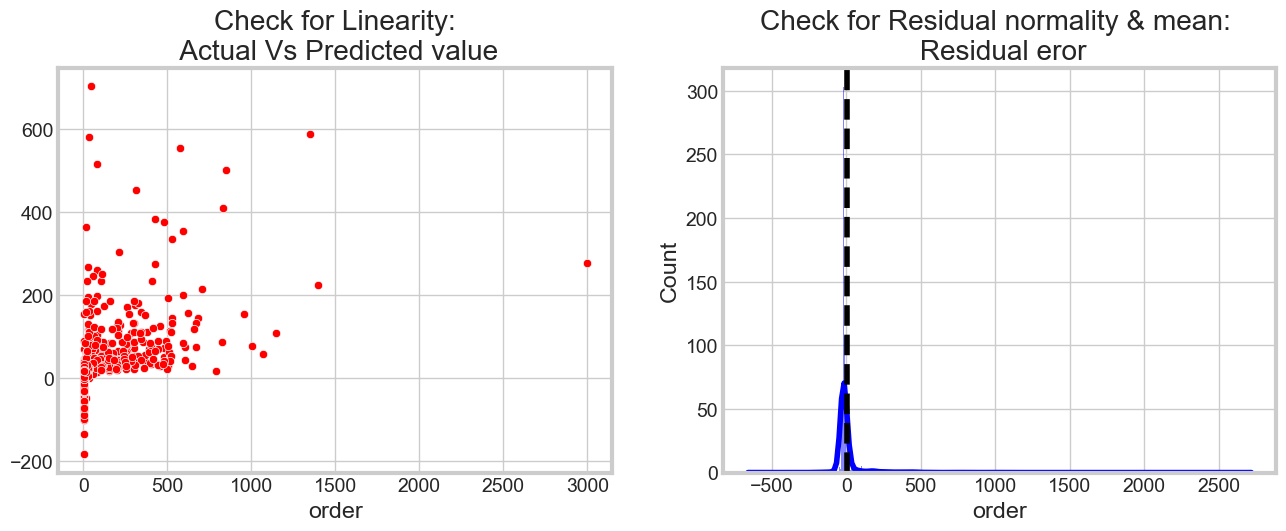

In [43]:
# Checking for linearity
f = plt.figure(figsize=(14,5))
ax = f.add_subplot(121)
sns.scatterplot(x=df_Y_Jan_test, y=y_pred_Jan, ax=ax, color='r')
ax.set_title('Check for Linearity:\n Actual Vs Predicted value')

# Checking for residual normality & mean
ax = f.add_subplot(122)
sns.histplot(x=(df_Y_Jan_test - y_pred_Jan), ax=ax, color='b', kde=True)
ax.axvline((df_Y_Jan_test - y_pred_Jan).mean(), color='k', linestyle='--')
ax.set_title('Check for Residual normality & mean: \n Residual eror');

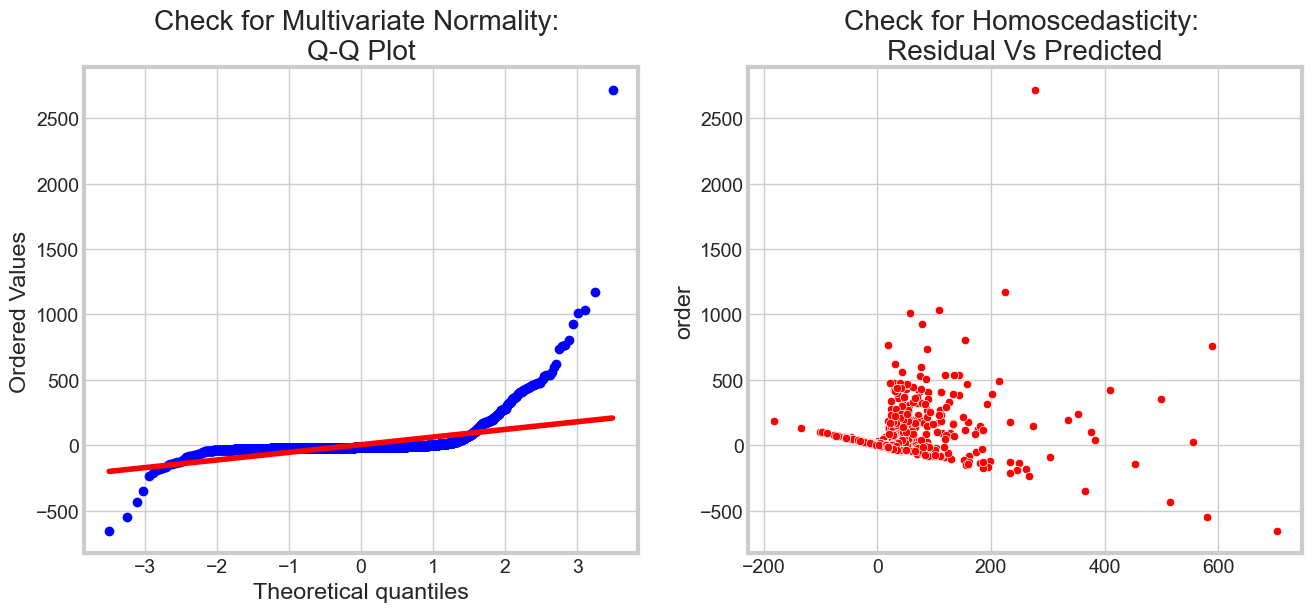

In [44]:
# Check for Multivariate Normality
# Quantile-Quantile plot
f,ax = plt.subplots(1,2,figsize=(14,6))
import scipy as sp
_,(_,_,r)= sp.stats.probplot((df_Y_Jan_test - y_pred_Jan), fit=True, plot=ax[0])
ax[0].set_title('Check for Multivariate Normality: \nQ-Q Plot')

#Check for Homoscedasticity
sns.scatterplot(x=y_pred_Jan, y=(df_Y_Jan_test - y_pred_Jan), ax=ax[1], color='r') 
ax[1].set_title('Check for Homoscedasticity: \nResidual Vs Predicted');

# Febreuary Linear Regression

In [45]:
# train test split for Feb
df_X_Feb_train = df_Feb_train.drop('order',axis=1)
df_Y_Feb_train= df_Feb_train['order']
df_X_Feb_test= df_Feb_test.drop('order',axis=1)
df_Y_Feb_test= df_Feb_test['order']

In [81]:
x_Feb= pd.concat([df_X_Feb_train,df_X_Feb_test])
display(x_Feb)

,itemID,salesPrice,brand,manufacturer,customerRating,recommendedRetailPrice
time,,,,,,
2018-02-01,9260,229.98,0,239,4.0,65.55
2018-02-01,6940,7.12,0,137,0.0,11.12
2018-02-01,8908,299.00,190,237,0.0,299.90
2018-02-01,4359,14.64,0,61,1.0,7.04
2018-02-01,5411,11.07,0,160,5.0,10.36
...,...,...,...,...,...,...
2018-02-28,3208,126.90,70,84,0.0,19.67
2018-02-28,5549,68.72,0,159,0.0,13.45
2018-02-28,9519,1036.92,196,235,3.0,500.31


In [46]:
from sklearn.linear_model import LinearRegression
lin_reg_Feb = LinearRegression()
lin_reg_Feb.fit(df_X_Feb_train, df_Y_Feb_train);

In [47]:
y_pred_Feb = lin_reg_Feb.predict(df_X_Feb_test)

# Evaluation
from sklearn.metrics import mean_squared_error
rmse_Feb = mean_squared_error(y_pred_Feb, df_Y_Feb_test, squared=False)

# R_square
R_square_Feb = lin_reg_Feb.score(df_X_Feb_test,df_Y_Feb_test)

#Mean absolute error
from sklearn.metrics import mean_absolute_error
mean_absolute_error_Feb=mean_absolute_error(df_Y_Feb_test, y_pred_Feb)
    
print('The root mean square error (RMSE) is: ', rmse_Feb)
print('R^2 obtained is:', R_square_Feb)
print('Mean absolute error obtained is:', mean_absolute_error_Feb)

The root mean square error (RMSE) is:  126.45044770712335
R^2 obtained is: 0.10732389632492978
Mean absolute error obtained is: 42.893266210267974


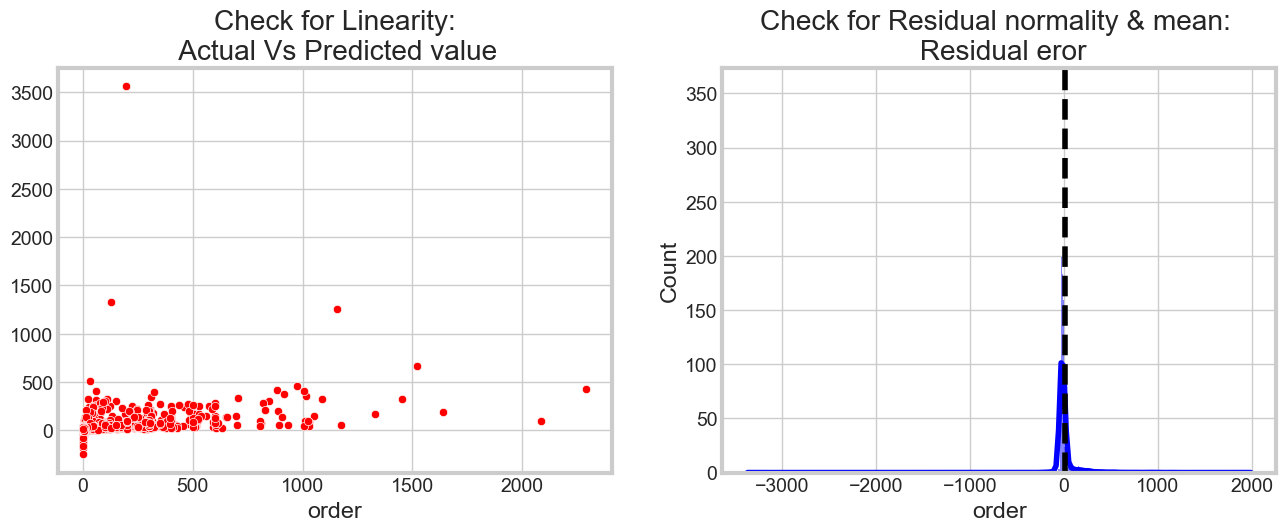

In [48]:
# Checking for linearity
f = plt.figure(figsize=(14,5))
ax = f.add_subplot(121)
sns.scatterplot(x=df_Y_Feb_test, y=y_pred_Feb, ax=ax, color='r')
ax.set_title('Check for Linearity:\n Actual Vs Predicted value')

# Checking for residual normality & mean
ax = f.add_subplot(122)
sns.histplot(x=(df_Y_Feb_test - y_pred_Feb), ax=ax, color='b', kde=True)
ax.axvline((df_Y_Feb_test - y_pred_Feb).mean(), color='k', linestyle='--')
ax.set_title('Check for Residual normality & mean: \n Residual eror');

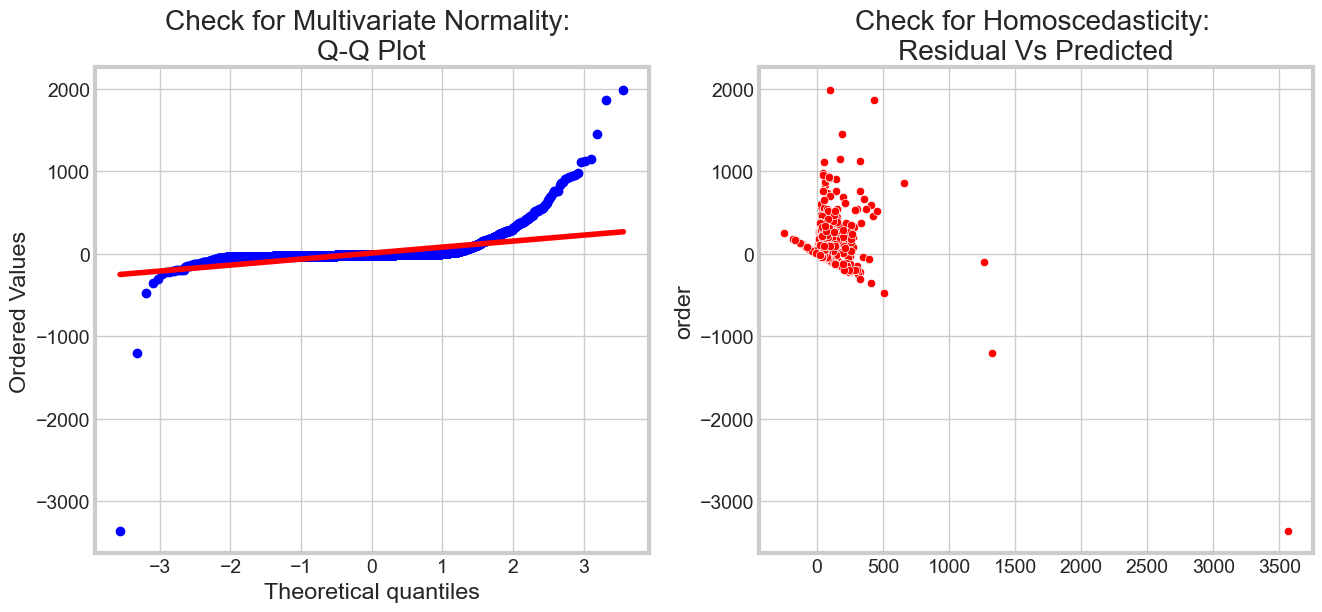

In [49]:
# Check for Multivariate Normality
# Quantile-Quantile plot
f,ax = plt.subplots(1,2,figsize=(14,6))
import scipy as sp
_,(_,_,r)= sp.stats.probplot((df_Y_Feb_test - y_pred_Feb), fit=True, plot=ax[0])
ax[0].set_title('Check for Multivariate Normality: \nQ-Q Plot')

#Check for Homoscedasticity
sns.scatterplot(x=y_pred_Feb, y=(df_Y_Feb_test - y_pred_Feb), ax=ax[1], color='r') 
ax[1].set_title('Check for Homoscedasticity: \nResidual Vs Predicted');

# March Linear Regression

In [50]:
# train test split for March
df_X_Mar_train = df_Mar_train.drop('order',axis=1)
df_Y_Mar_train= df_Mar_train['order']
df_X_Mar_test= df_Mar_test.drop('order',axis=1)
df_Y_Mar_test= df_Mar_test['order']

In [82]:
x_Mar= pd.concat([df_X_Mar_train,df_X_Mar_test])
display(x_Mar)

,itemID,salesPrice,brand,manufacturer,customerRating,recommendedRetailPrice
time,,,,,,
2018-03-01,8461,2311.28,116,121,0.0,12.89
2018-03-01,7871,12.49,116,121,5.0,27.38
2018-03-01,3216,322.00,0,85,0.0,10.35
2018-03-01,3240,603.52,0,85,0.0,11.34
2018-03-01,3241,1419.00,0,85,0.0,16.84
...,...,...,...,...,...,...
2018-03-31,3234,32.73,0,85,5.0,19.37
2018-03-31,3177,886.14,68,83,0.0,55.77
2018-03-31,8081,3.26,117,205,0.0,7.61


In [51]:
from sklearn.linear_model import LinearRegression
lin_reg_Mar = LinearRegression()
lin_reg_Mar.fit(df_X_Mar_train, df_Y_Mar_train);

In [52]:
y_pred_Mar= lin_reg_Mar.predict(df_X_Mar_test)

# Evaluation
from sklearn.metrics import mean_squared_error
rmse_Mar = mean_squared_error(y_pred_Mar, df_Y_Mar_test, squared=False)

# R_square
R_square_Mar= lin_reg_Mar.score(df_X_Mar_test,df_Y_Mar_test)


#Mean absolute error
from sklearn.metrics import mean_absolute_error
mean_absolute_error_Mar= mean_absolute_error(df_Y_Mar_test, y_pred_Mar)

print('The root mean square error (RMSE) is: ', rmse_Mar)
print('R^2 obtained is:', R_square_Mar)
print('Mean absolute error obtained is:', mean_absolute_error_Mar)

The root mean square error (RMSE) is:  114.97431703148627
R^2 obtained is: 0.13988280788470697
Mean absolute error obtained is: 40.31833555370192


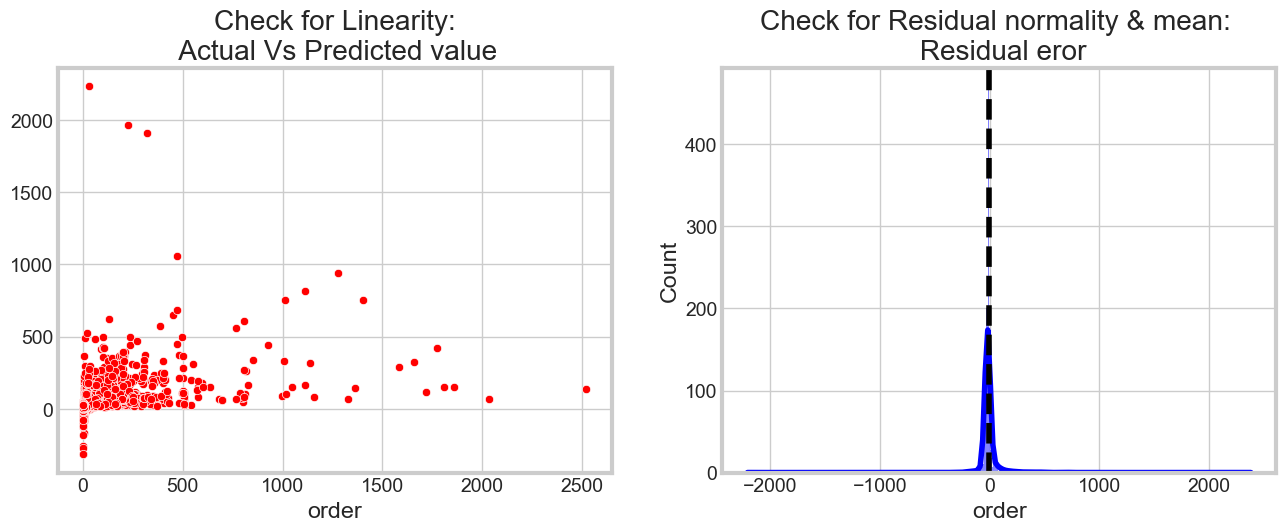

In [53]:
# Checking for linearity
f = plt.figure(figsize=(14,5))
ax = f.add_subplot(121)
sns.scatterplot(x=df_Y_Mar_test, y=y_pred_Mar, ax=ax, color='r')
ax.set_title('Check for Linearity:\n Actual Vs Predicted value')

# Checking for residual normality & mean
ax = f.add_subplot(122)
sns.histplot(x=(df_Y_Mar_test - y_pred_Mar), ax=ax, color='b', kde=True)
ax.axvline((df_Y_Mar_test - y_pred_Mar).mean(), color='k', linestyle='--')
ax.set_title('Check for Residual normality & mean: \n Residual eror');

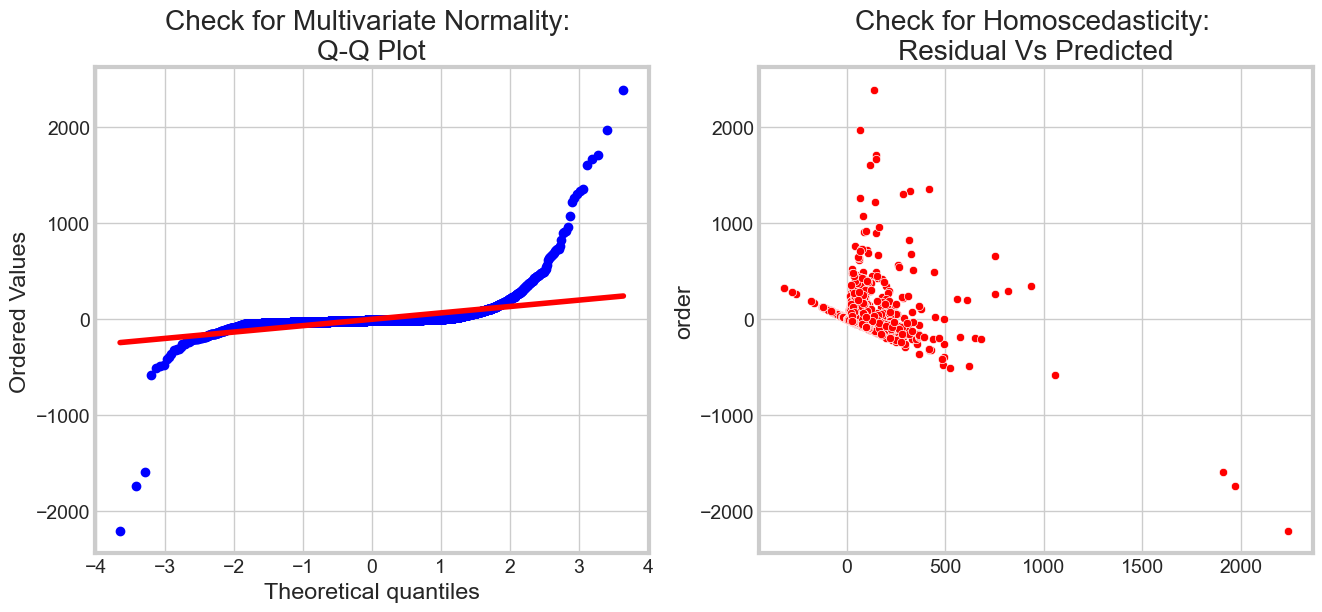

In [54]:
# Check for Multivariate Normality
# Quantile-Quantile plot
f,ax = plt.subplots(1,2,figsize=(14,6))
import scipy as sp
_,(_,_,r)= sp.stats.probplot((df_Y_Mar_test - y_pred_Mar), fit=True, plot=ax[0])
ax[0].set_title('Check for Multivariate Normality: \nQ-Q Plot')

#Check for Homoscedasticity
sns.scatterplot(x=y_pred_Mar, y=(df_Y_Mar_test - y_pred_Mar), ax=ax[1], color='r') 
ax[1].set_title('Check for Homoscedasticity: \nResidual Vs Predicted');

# April Linear Regression

In [55]:
# train test split for April
df_X_Apr_train = df_Apr_train.drop('order',axis=1)
df_Y_Apr_train= df_Apr_train['order']
df_X_Apr_test= df_Apr_test.drop('order',axis=1)
df_Y_Apr_test= df_Apr_test['order']

In [83]:
x_Apr= pd.concat([df_X_Apr_train,df_X_Apr_test])
display(x_Apr)

,itemID,salesPrice,brand,manufacturer,customerRating,recommendedRetailPrice
time,,,,,,
2018-04-01,3192,24.37,66,82,0.0,25.38
2018-04-01,2412,81.35,41,65,4.0,67.09
2018-04-01,4258,3.66,0,102,0.0,9.28
2018-04-01,8278,3.28,0,213,5.0,5.38
2018-04-01,4260,2.94,0,102,4.0,6.84
...,...,...,...,...,...,...
2018-04-30,3662,15.61,76,86,0.0,25.66
2018-04-30,2541,7.58,29,58,0.0,18.75
2018-04-30,6493,10.30,0,172,4.7,14.93


In [56]:
from sklearn.linear_model import LinearRegression
lin_reg_Apr = LinearRegression()
lin_reg_Apr.fit(df_X_Apr_train, df_Y_Apr_train);

In [57]:
y_pred_Apr= lin_reg_Apr.predict(df_X_Apr_test)

# Evaluation
from sklearn.metrics import mean_squared_error
rmse_Apr = mean_squared_error(y_pred_Apr, df_Y_Apr_test, squared=False)

# R_square
R_square_Apr = lin_reg_Apr.score(df_X_Apr_test,df_Y_Apr_test)


#Mean absolute error
from sklearn.metrics import mean_absolute_error
mean_absolute_error_Apr= mean_absolute_error(df_Y_Apr_test, y_pred_Apr)

print('The root mean square error (RMSE) is: ', rmse_Apr)
print('R^2 obtained is:', R_square_Apr)
print('Mean absolute error obtained is:', mean_absolute_error_Apr)

The root mean square error (RMSE) is:  91.58758731517491
R^2 obtained is: 0.2820127439671205
Mean absolute error obtained is: 32.13338519526531


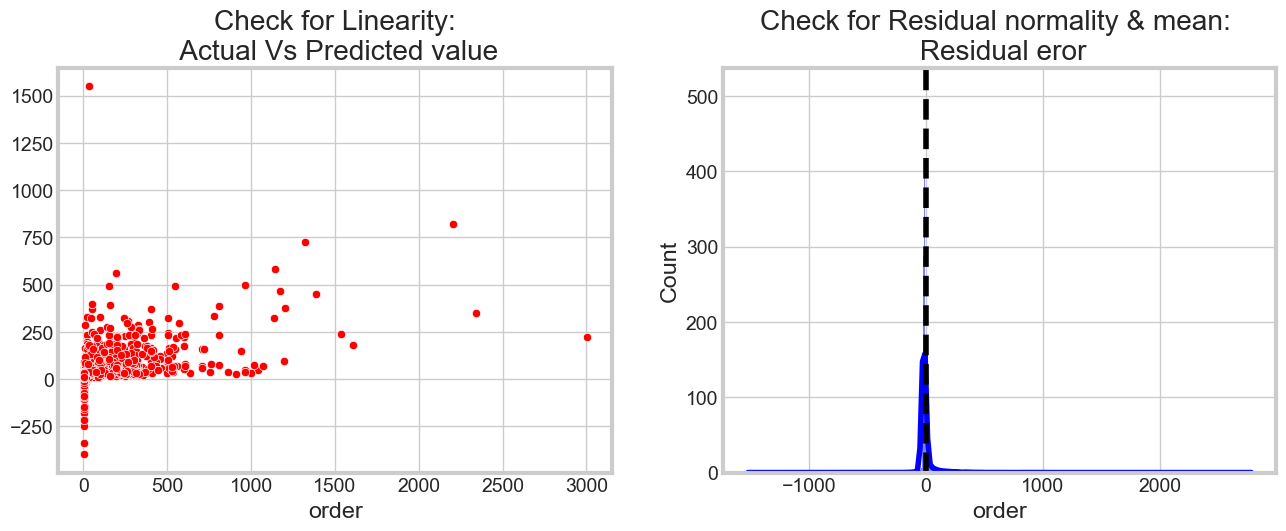

In [58]:
# Checking for linearity
f = plt.figure(figsize=(14,5))
ax = f.add_subplot(121)
sns.scatterplot(x=df_Y_Apr_test, y=y_pred_Apr, ax=ax, color='r')
ax.set_title('Check for Linearity:\n Actual Vs Predicted value')

# Checking for residual normality & mean
ax = f.add_subplot(122)
sns.histplot(x=(df_Y_Apr_test - y_pred_Apr), ax=ax, color='b', kde=True)
ax.axvline((df_Y_Apr_test - y_pred_Apr).mean(), color='k', linestyle='--')
ax.set_title('Check for Residual normality & mean: \n Residual eror');

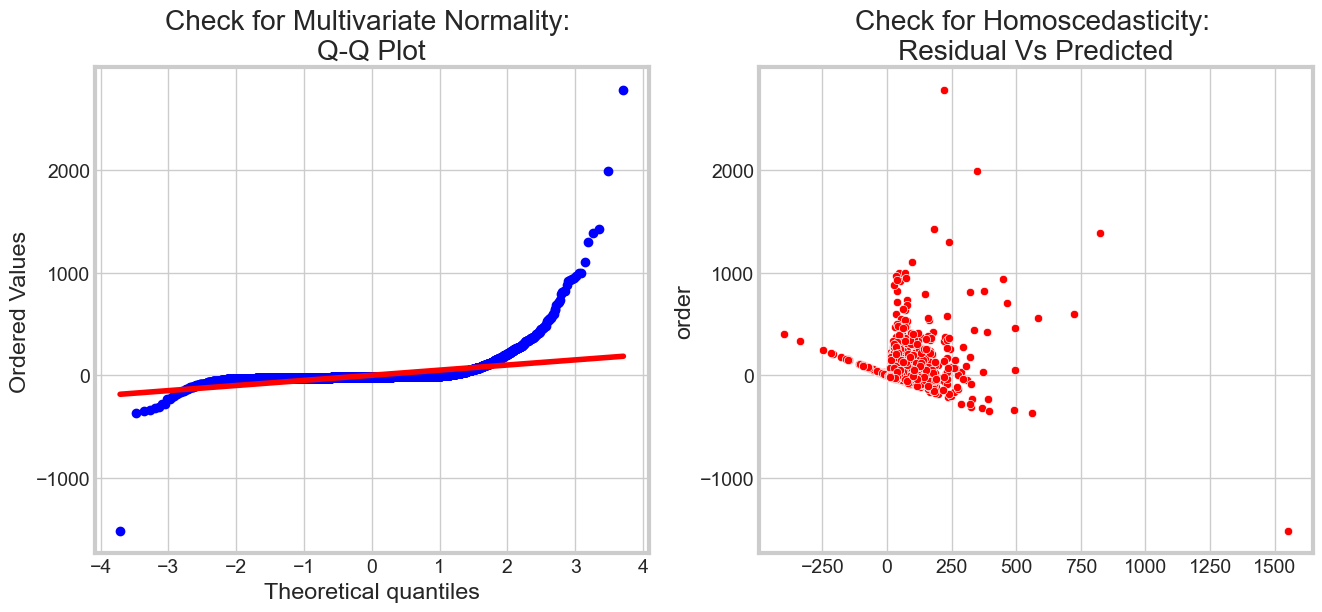

In [59]:
# Check for Multivariate Normality
# Quantile-Quantile plot
f,ax = plt.subplots(1,2,figsize=(14,6))
import scipy as sp
_,(_,_,r)= sp.stats.probplot((df_Y_Apr_test - y_pred_Apr), fit=True, plot=ax[0])
ax[0].set_title('Check for Multivariate Normality: \nQ-Q Plot')

#Check for Homoscedasticity
sns.scatterplot(x=y_pred_Apr, y=(df_Y_Apr_test - y_pred_Apr), ax=ax[1], color='r') 
ax[1].set_title('Check for Homoscedasticity: \nResidual Vs Predicted');

# May Linear Regression

In [60]:
# train test split for May
df_X_May_train = df_May_train.drop('order',axis=1)
df_Y_May_train= df_May_train['order']
df_X_May_test= df_May_test.drop('order',axis=1)
df_Y_May_test= df_May_test['order']

In [84]:
x_May= pd.concat([df_X_May_train,df_X_May_test])
display(x_May)

,itemID,salesPrice,brand,manufacturer,customerRating,recommendedRetailPrice
time,,,,,,
2018-05-01,5846,9746.40,0,162,5.0,11.64
2018-05-01,698,58.51,0,2,4.5,31.87
2018-05-01,2614,2.39,0,70,0.0,7.35
2018-05-01,3764,64.02,70,84,0.0,34.11
2018-05-01,6897,7.63,93,172,0.0,12.38
...,...,...,...,...,...,...
2018-05-31,491,15.44,0,24,5.0,15.04
2018-05-31,3990,1652.35,0,84,0.0,25.40
2018-05-31,5351,2315.04,0,104,0.0,31.51


In [61]:
from sklearn.linear_model import LinearRegression
lin_reg_May = LinearRegression()
lin_reg_May.fit(df_X_May_train, df_Y_May_train);

In [62]:
y_pred_May= lin_reg_May.predict(df_X_May_test)

# Evaluation
from sklearn.metrics import mean_squared_error
rmse_May = mean_squared_error(y_pred_May, df_Y_May_test, squared=False)

# R_square
R_square_May = lin_reg_May.score(df_X_May_test,df_Y_May_test)


#Mean absolute error
from sklearn.metrics import mean_absolute_error
mean_absolute_error_May= mean_absolute_error(df_Y_May_test, y_pred_May)

print('The root mean square error (RMSE) is: ', rmse_May)
print('R^2 obtained is:', R_square_May)
print('Mean absolute error obtained is:', mean_absolute_error_May)

The root mean square error (RMSE) is:  92.1823124207646
R^2 obtained is: 0.14206096143931313
Mean absolute error obtained is: 30.26474058164395


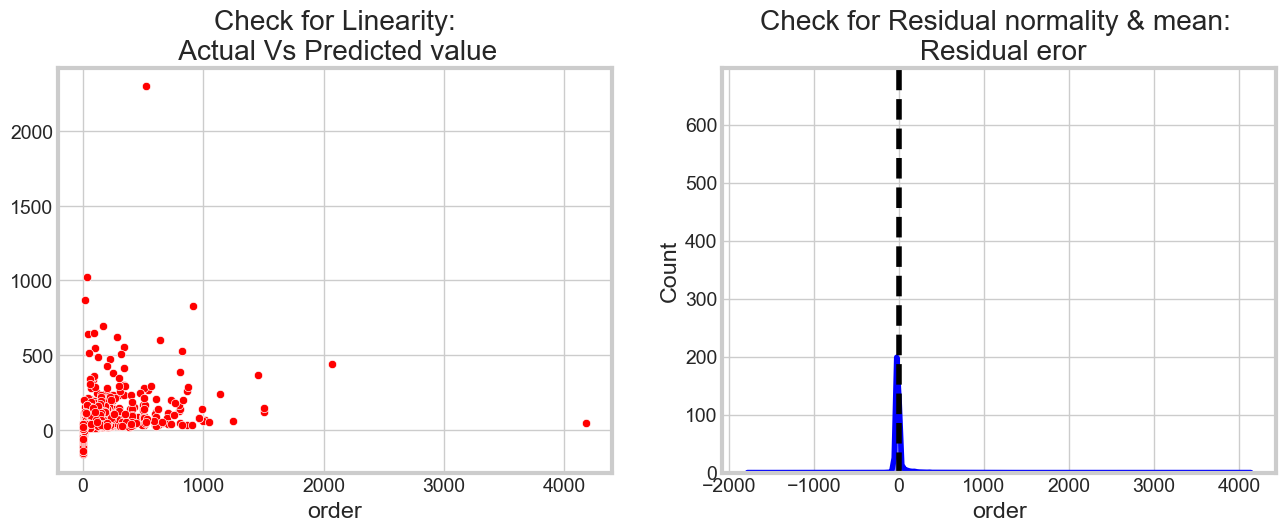

In [63]:
# Checking for linearity
f = plt.figure(figsize=(14,5))
ax = f.add_subplot(121)
sns.scatterplot(x=df_Y_May_test, y=y_pred_May, ax=ax, color='r')
ax.set_title('Check for Linearity:\n Actual Vs Predicted value')

# Checking for residual normality & mean
ax = f.add_subplot(122)
sns.histplot(x=(df_Y_May_test - y_pred_May), ax=ax, color='b', kde=True)
ax.axvline((df_Y_May_test - y_pred_May).mean(), color='k', linestyle='--')
ax.set_title('Check for Residual normality & mean: \n Residual eror');

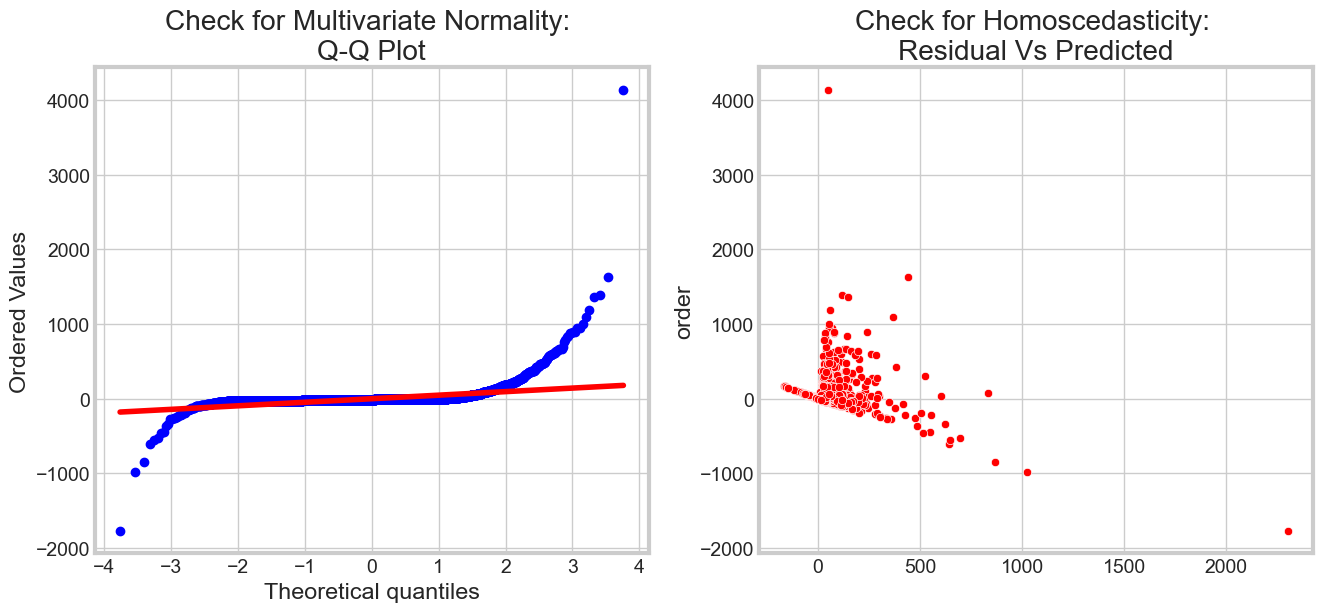

In [64]:
# Check for Multivariate Normality
# Quantile-Quantile plot
f,ax = plt.subplots(1,2,figsize=(14,6))
import scipy as sp
_,(_,_,r)= sp.stats.probplot((df_Y_May_test - y_pred_May), fit=True, plot=ax[0])
ax[0].set_title('Check for Multivariate Normality: \nQ-Q Plot')

#Check for Homoscedasticity
sns.scatterplot(x=y_pred_May, y=(df_Y_May_test - y_pred_May), ax=ax[1], color='r') 
ax[1].set_title('Check for Homoscedasticity: \nResidual Vs Predicted');

# June Linear Regression

In [65]:
# train test split for June
df_X_Jun_train = df_Jun_train.drop('order',axis=1)
df_Y_Jun_train= df_Jun_train['order']
df_X_Jun_test= df_Jun_test.drop('order',axis=1)
df_Y_Jun_test= df_Jun_test['order']

In [85]:
x_Jun= pd.concat([df_X_Jun_train,df_X_Jun_test])
display(x_Jun)

,itemID,salesPrice,brand,manufacturer,customerRating,recommendedRetailPrice
time,,,,,,
2018-06-01,3893,87.10,74,86,1.00,37.00
2018-06-01,998,3.97,0,30,5.00,25.59
2018-06-01,10226,18112.90,178,225,0.00,1178.00
2018-06-01,10225,2618.60,178,225,0.00,1504.50
2018-06-01,1875,35.80,0,39,4.20,27.39
...,...,...,...,...,...,...
2018-06-29,8258,1.93,0,121,0.00,7.48
2018-06-29,7892,7.43,0,213,0.00,9.59
2018-06-29,7263,3.85,0,179,0.00,7.23


In [66]:
from sklearn.linear_model import LinearRegression
lin_reg_Jun = LinearRegression()
lin_reg_Jun.fit(df_X_Jun_train, df_Y_Jun_train);

In [67]:
y_pred_Jun= lin_reg_Jun.predict(df_X_Jun_test)

# Evaluation
from sklearn.metrics import mean_squared_error
rmse_Jun = mean_squared_error(y_pred_Jun, df_Y_Jun_test, squared=False)

# R_square
R_square_Jun = lin_reg_Jun.score(df_X_Jun_test,df_Y_Jun_test)


#Mean absolute error
from sklearn.metrics import mean_absolute_error
mean_absolute_error_Jun= mean_absolute_error(df_Y_Jun_test, y_pred_Jun)

print('The root mean square error (RMSE) is: ', rmse_Jun)
print('R^2 obtained is:', R_square_Jun)
print('Mean absolute error obtained is:', mean_absolute_error_Jun)

The root mean square error (RMSE) is:  89.14026398684042
R^2 obtained is: 0.25155563513572265
Mean absolute error obtained is: 31.96852827525528


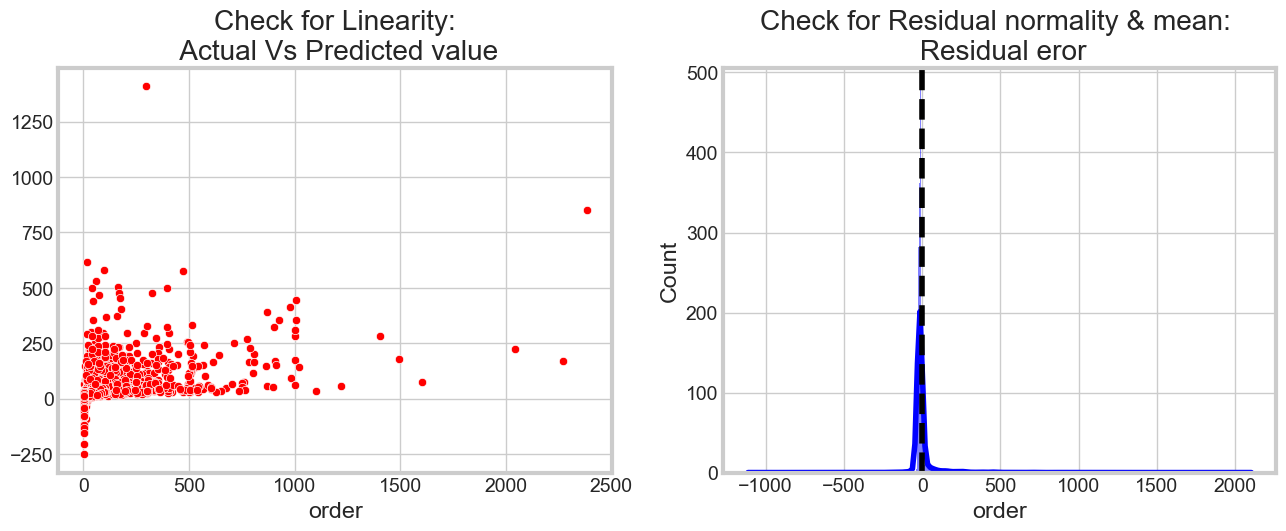

In [68]:
# Checking for linearity
f = plt.figure(figsize=(14,5))
ax = f.add_subplot(121)
sns.scatterplot(x=df_Y_Jun_test, y=y_pred_Jun, ax=ax, color='r')
ax.set_title('Check for Linearity:\n Actual Vs Predicted value')

# Checking for residual normality & mean
ax = f.add_subplot(122)
sns.histplot(x=(df_Y_Jun_test - y_pred_Jun), ax=ax, color='b', kde=True)
ax.axvline((df_Y_Jun_test - y_pred_Jun).mean(), color='k', linestyle='--')
ax.set_title('Check for Residual normality & mean: \n Residual eror');

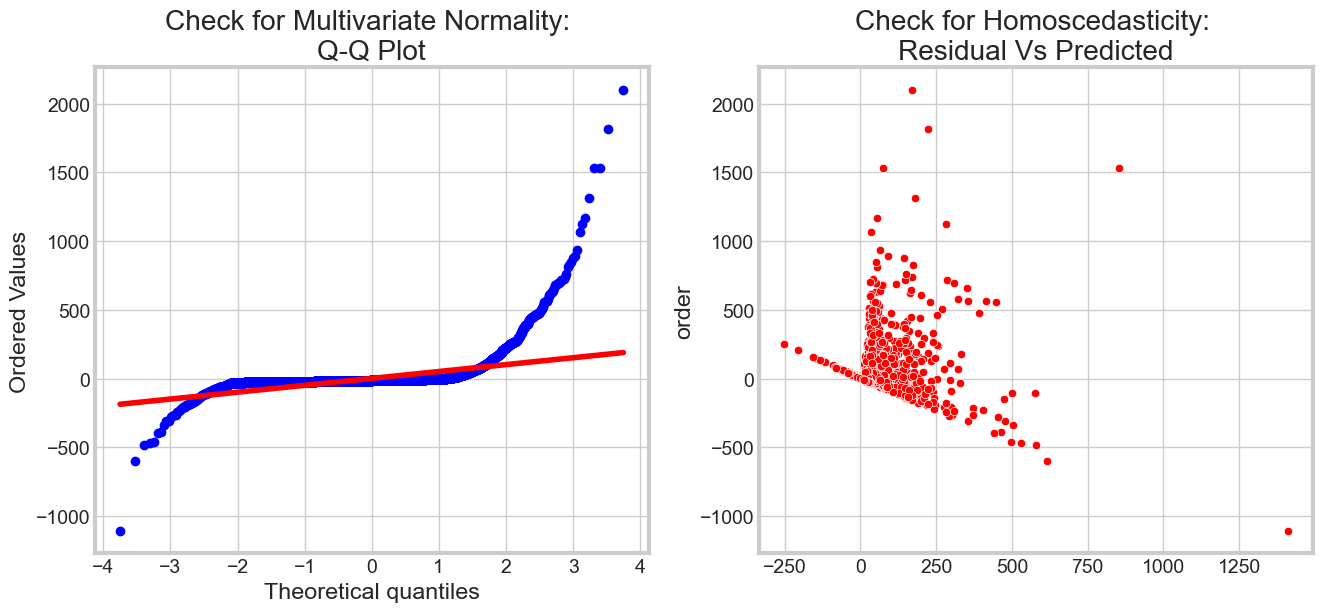

In [69]:
# Check for Multivariate Normality
# Quantile-Quantile plot
f,ax = plt.subplots(1,2,figsize=(14,6))
import scipy as sp
_,(_,_,r)= sp.stats.probplot((df_Y_Jun_test - y_pred_Jun), fit=True, plot=ax[0])
ax[0].set_title('Check for Multivariate Normality: \nQ-Q Plot')

#Check for Homoscedasticity
sns.scatterplot(x=y_pred_Jun, y=(df_Y_Jun_test - y_pred_Jun), ax=ax[1], color='r') 
ax[1].set_title('Check for Homoscedasticity: \nResidual Vs Predicted');

# Evaluating The Linear Regression for the six months

In [70]:
# we will get the mean of every evaluation criteria over the 6 months
import statistics
mean_rmse_lin=statistics.mean([rmse_Jan, rmse_Feb, rmse_Mar, rmse_Apr, rmse_May, rmse_Jun])
mean_R_square_lin=statistics.mean([R_square_Jan, R_square_Feb, R_square_Mar, R_square_Apr, R_square_May, R_square_Jun])
mean_mean_absolute_error_lin=statistics.mean([mean_absolute_error_Jan, mean_absolute_error_Feb, mean_absolute_error_Mar,mean_absolute_error_Apr, mean_absolute_error_May, mean_absolute_error_Jun])

print("Mean of root mean square error (RMSE) for 6 months for linear regression model is ", mean_rmse_lin)
print("Mean of R^2 obtained for 6 months for linear regression model is ", mean_R_square_lin)
print("Mean of Mean absolute error obtained for 6 months for linear regression model is ", mean_mean_absolute_error_lin)

Mean of root mean square error (RMSE) for 6 months for linear regression model is  102.89129447846894
Mean of R^2 obtained for 6 months for linear regression model is  0.19285211158286
Mean of Mean absolute error obtained for 6 months for linear regression model is  35.86336925289069


# January Decision Tree Regression

In [78]:
from sklearn.tree import DecisionTreeRegressor
Tree_reg_Jan= DecisionTreeRegressor(max_depth=4, min_samples_split= 5, random_state=42)

In [79]:
Tree_reg_Jan.fit(df_X_Jan_train,df_Y_Jan_train);

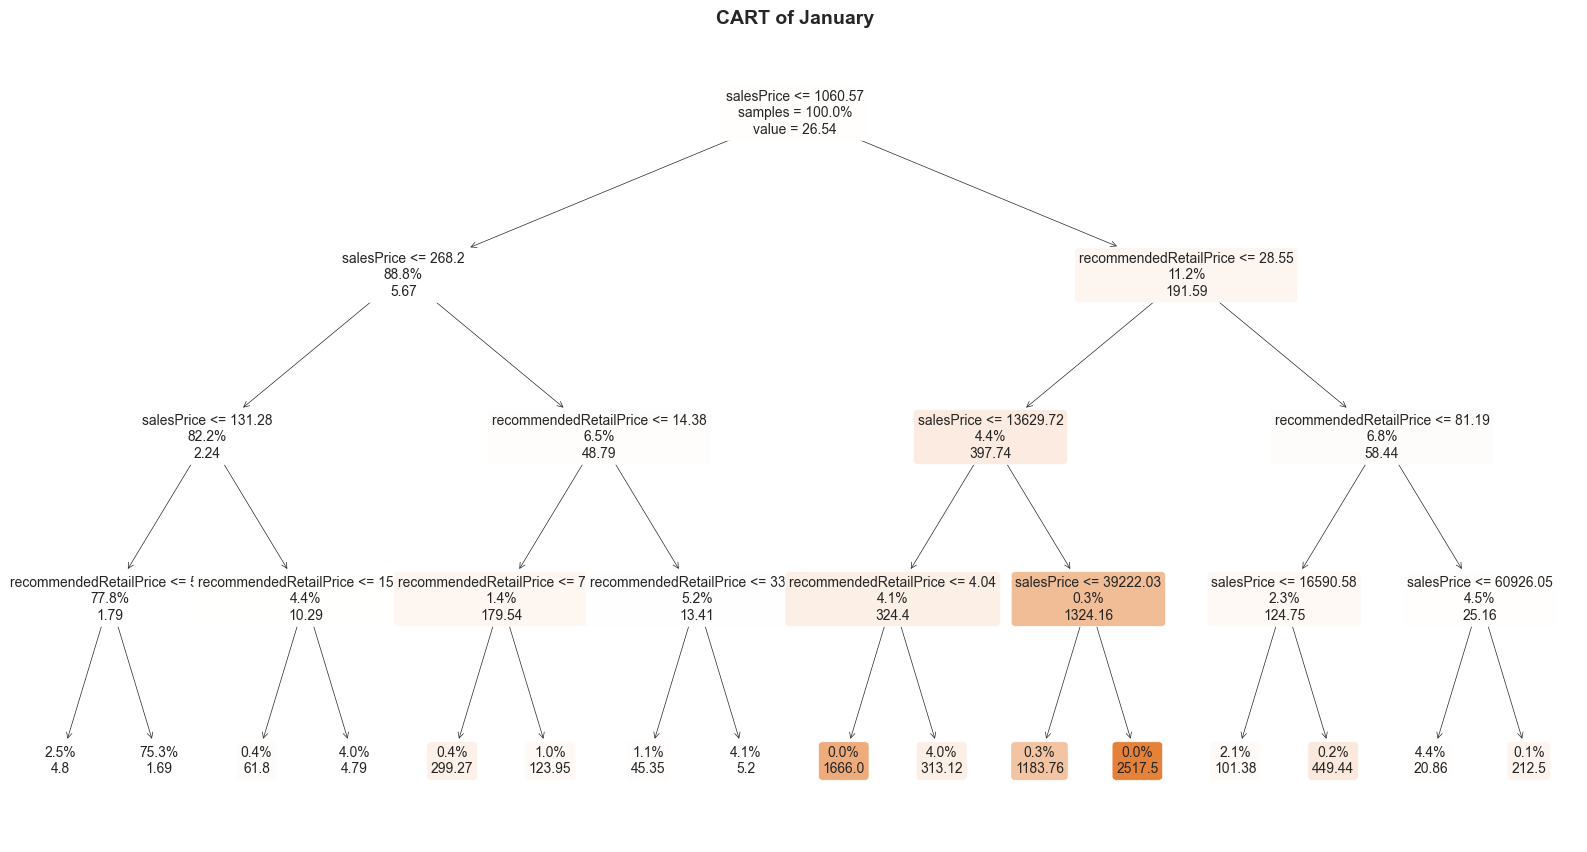

In [80]:
from sklearn.tree import plot_tree
plt.figure(figsize=(18, 10))  # Adjust the figsize as needed

# Call plot_tree with appropriate parameters
plot_tree(Tree_reg_Jan, feature_names=x_Jan.columns, filled=True, fontsize=10, rounded=True,
          label='root', impurity=False, precision=2, class_names=True,
          proportion=True)

# Customize the text labels for better readability
text_settings = {'fontsize': 10, 'color': 'black', 'alpha': 1.0, 'ha': 'center', 'va': 'center', 'weight': 'bold'}
fontdict = {'fontsize': 12, 'fontweight': 'bold'}

plt.title("CART of January", fontsize=14, fontweight='bold')
plt.xlabel("Feature", fontsize=12)
plt.ylabel("Target", fontsize=12)

plt.show()

In [73]:

# sklearn CART module
y_pred_tree_Jan = Tree_reg_Jan.predict(df_X_Jan_test)

# Evaluation
#from sklearn.metrics import mean_squared_error
rmse_tree_Jan = mean_squared_error(y_pred_tree_Jan, df_Y_Jan_test, squared=False)

# R_square
R_square_tree_Jan= Tree_reg_Jan.score(df_X_Jan_test,df_Y_Jan_test)


#Mean absolute error
mean_absolute_error_tree_Jan= mean_absolute_error(df_Y_Jan_test, y_pred_tree_Jan)

print('The root mean square error (RMSE) is: ', rmse_tree_Jan)
print('R^2 obtained is:', R_square_tree_Jan)
print('Mean absolute error obtained is:', mean_absolute_error_tree_Jan)


The root mean square error (RMSE) is:  68.43932494507854
R^2 obtained is: 0.6620125055199838
Mean absolute error obtained is: 15.516176479195153


# February Decision Tree Regression

In [87]:
Tree_reg_Feb= DecisionTreeRegressor(max_depth=4, min_samples_split= 5, random_state=42)

In [88]:
Tree_reg_Feb.fit(df_X_Feb_train,df_Y_Feb_train);

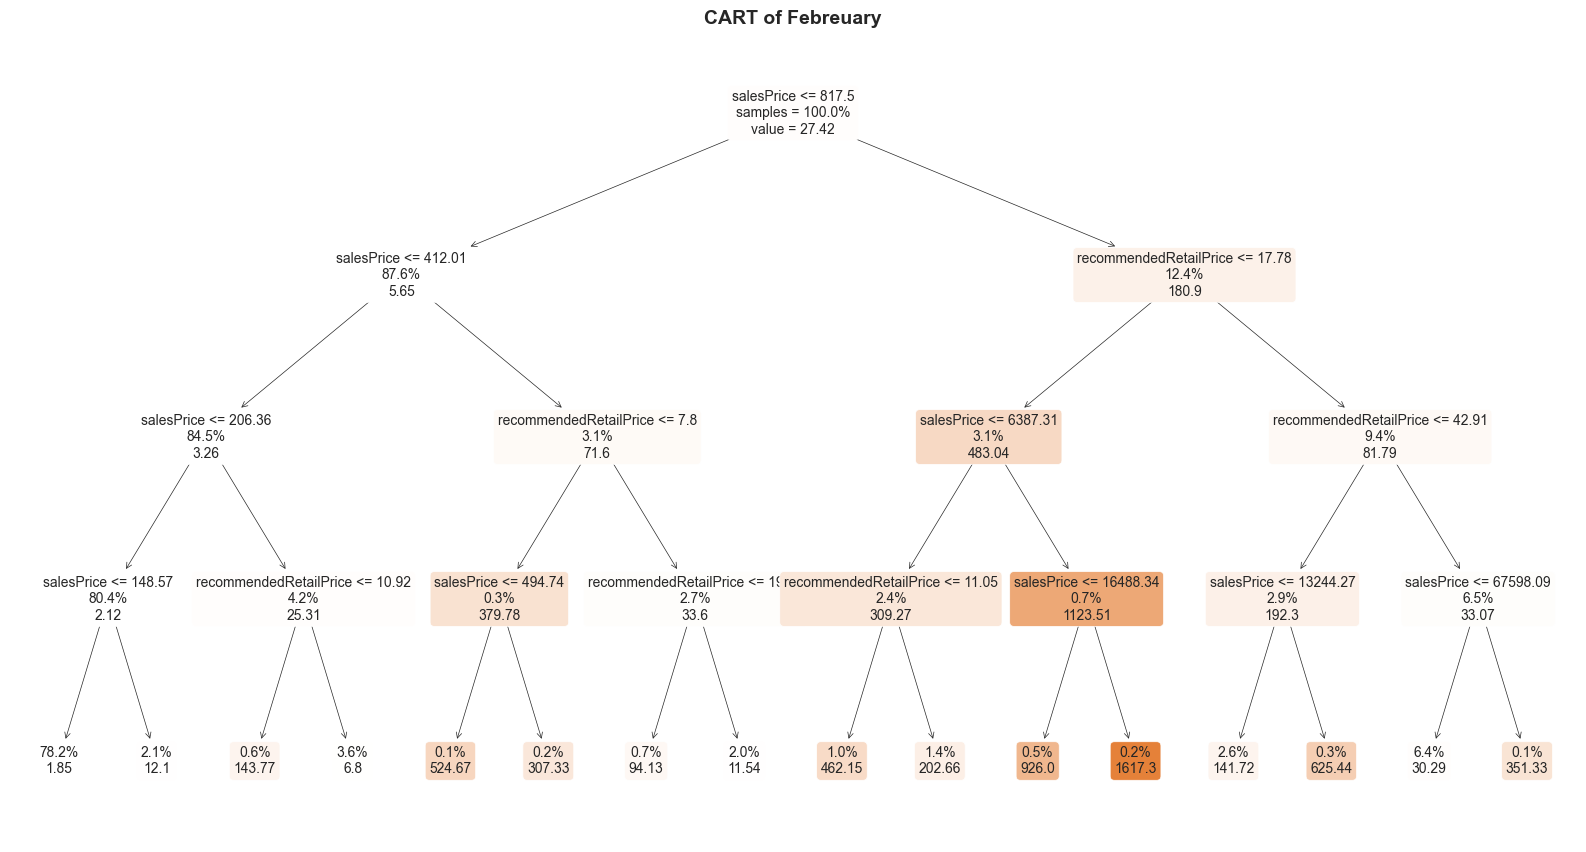

In [89]:

plt.figure(figsize=(18, 10))  # Adjust the figsize as needed

# Call plot_tree with appropriate parameters
plot_tree(Tree_reg_Feb, feature_names=x_Feb.columns, filled=True, fontsize=10, rounded=True,
          label='root', impurity=False, precision=2, class_names=True,
          proportion=True)

# Customize the text labels for better readability
text_settings = {'fontsize': 10, 'color': 'black', 'alpha': 1.0, 'ha': 'center', 'va': 'center', 'weight': 'bold'}
fontdict = {'fontsize': 12, 'fontweight': 'bold'}

plt.title("CART of Febreuary", fontsize=14, fontweight='bold')
plt.xlabel("Feature", fontsize=12)
plt.ylabel("Target", fontsize=12)

plt.show()

In [76]:
# sklearn regression module
y_pred_tree_Feb = Tree_reg_Feb.predict(df_X_Feb_test)

# Evaluation
#from sklearn.metrics import mean_squared_error
rmse_tree_Feb = mean_squared_error(y_pred_tree_Feb, df_Y_Feb_test, squared=False)

# R_square
R_square_tree_Feb= Tree_reg_Feb.score(df_X_Feb_test,df_Y_Feb_test)


#Mean absolute error
mean_absolute_error_tree_Feb= mean_absolute_error(df_Y_Feb_test, y_pred_tree_Feb)

print('The root mean square error (RMSE) is: ', rmse_tree_Feb)
print('R^2 obtained is:', R_square_tree_Feb)
print('Mean absolute error obtained is:', mean_absolute_error_tree_Feb)


The root mean square error (RMSE) is:  86.01768899729383
R^2 obtained is: 0.5869251943355642
Mean absolute error obtained is: 21.213766863579202


# March Decision Tree Regression

In [90]:
Tree_reg_Mar= DecisionTreeRegressor(max_depth=4, min_samples_split= 5, random_state=42)

In [91]:
Tree_reg_Mar.fit(df_X_Mar_train,df_Y_Mar_train);

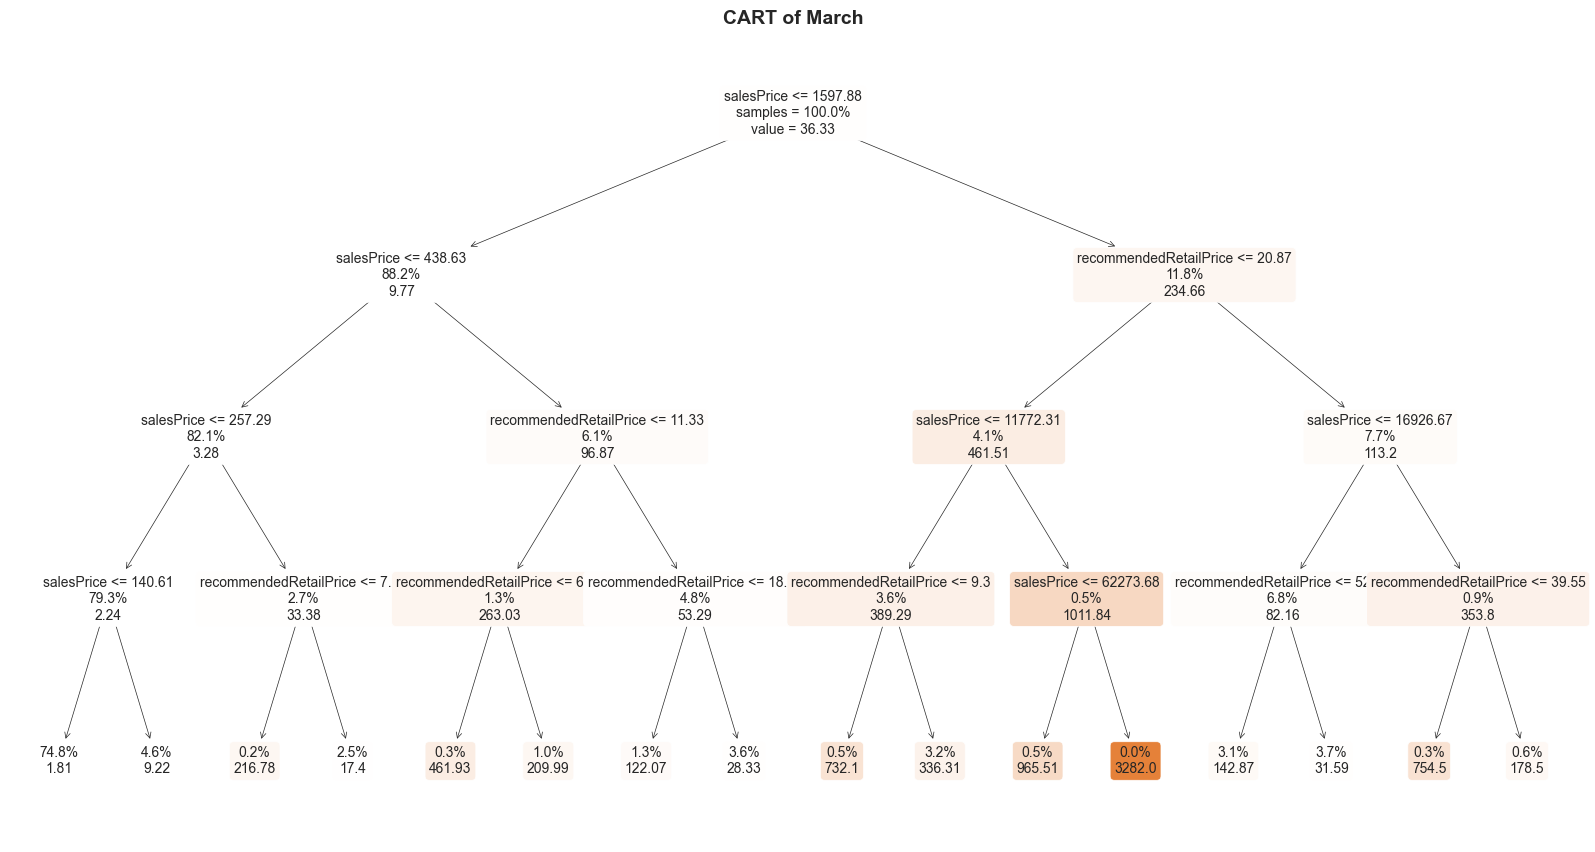

In [92]:
plt.figure(figsize=(18, 10))  # Adjust the figsize as needed

# Call plot_tree with appropriate parameters
plot_tree(Tree_reg_Mar, feature_names=x_Mar.columns, filled=True, fontsize=10, rounded=True,
          label='root', impurity=False, precision=2, class_names=True,
          proportion=True)

# Customize the text labels for better readability
text_settings = {'fontsize': 10, 'color': 'black', 'alpha': 1.0, 'ha': 'center', 'va': 'center', 'weight': 'bold'}
fontdict = {'fontsize': 12, 'fontweight': 'bold'}

plt.title("CART of March", fontsize=14, fontweight='bold')
plt.xlabel("Feature", fontsize=12)
plt.ylabel("Target", fontsize=12)

plt.show()

In [79]:
# sklearn regression module
y_pred_tree_Mar = Tree_reg_Mar.predict(df_X_Mar_test)

# Evaluation
#from sklearn.metrics import mean_squared_error
rmse_tree_Mar = mean_squared_error(y_pred_tree_Mar, df_Y_Mar_test, squared=False)

# R_square
R_square_tree_Mar= Tree_reg_Mar.score(df_X_Mar_test,df_Y_Mar_test)


#Mean absolute error
mean_absolute_error_tree_Mar= mean_absolute_error(df_Y_Mar_test, y_pred_tree_Mar)

print('The root mean square error (RMSE) is: ', rmse_tree_Mar)
print('R^2 obtained is:', R_square_tree_Mar)
print('Mean absolute error obtained is:', mean_absolute_error_tree_Mar)


The root mean square error (RMSE) is:  73.22336261146502
R^2 obtained is: 0.6511366960832984
Mean absolute error obtained is: 17.60656460728712



# April Decision Tree Regression

In [93]:
Tree_reg_Apr= DecisionTreeRegressor(max_depth=4, min_samples_split= 5, random_state=42)

In [94]:
Tree_reg_Apr.fit(df_X_Apr_train,df_Y_Apr_train);

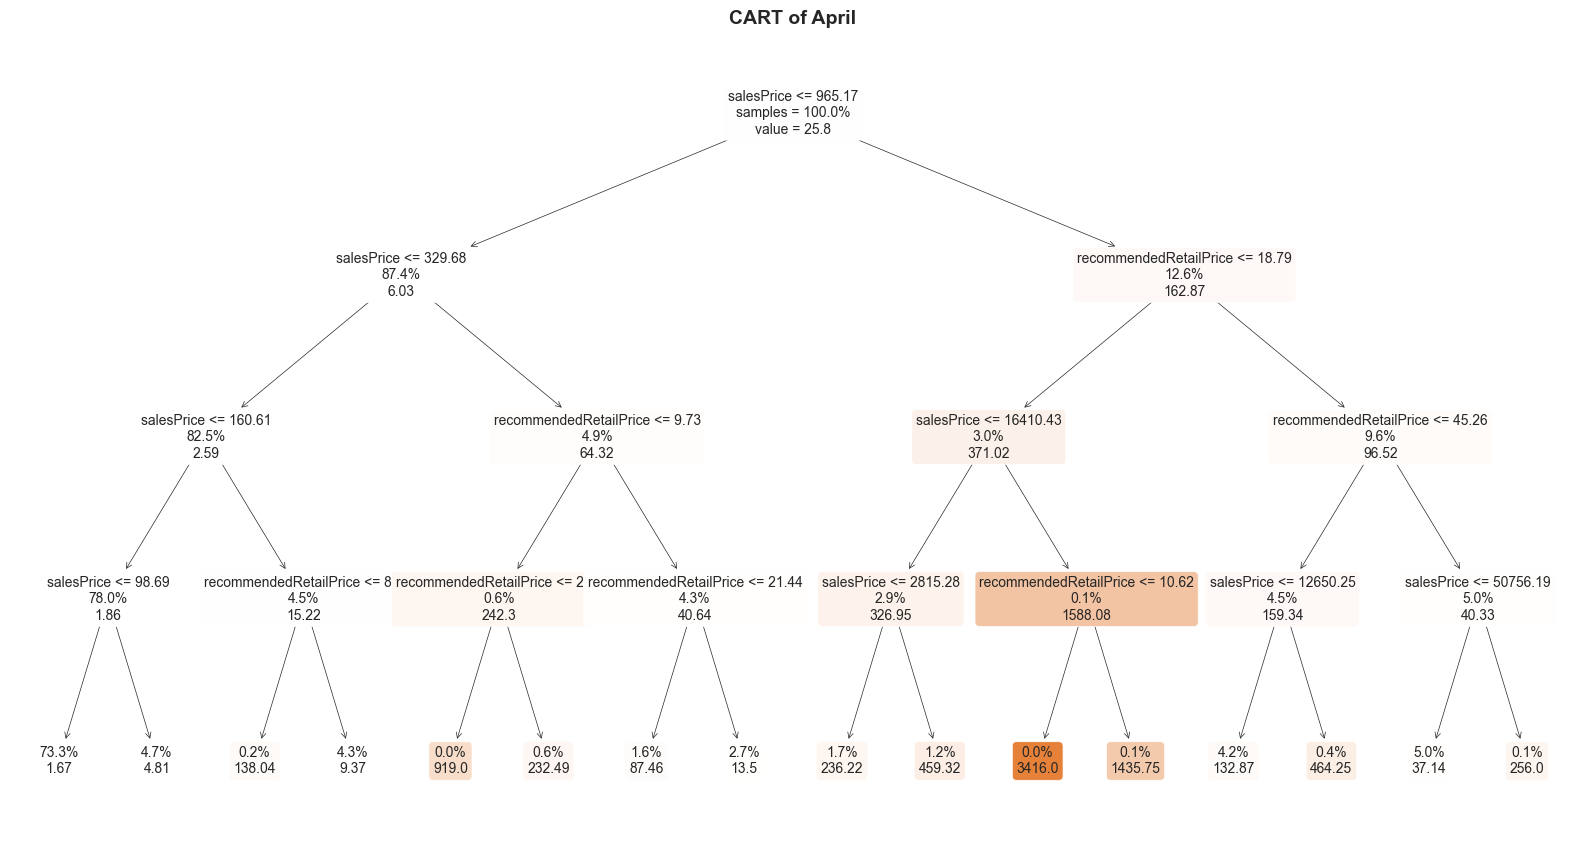

In [95]:
plt.figure(figsize=(18, 10))  # Adjust the figsize as needed

# Call plot_tree with appropriate parameters
plot_tree(Tree_reg_Apr, feature_names=x_Apr.columns, filled=True, fontsize=10, rounded=True,
          label='root', impurity=False, precision=2, class_names=True,
          proportion=True)

# Customize the text labels for better readability
text_settings = {'fontsize': 10, 'color': 'black', 'alpha': 1.0, 'ha': 'center', 'va': 'center', 'weight': 'bold'}
fontdict = {'fontsize': 12, 'fontweight': 'bold'}

plt.title("CART of April", fontsize=14, fontweight='bold')
plt.xlabel("Feature", fontsize=12)
plt.ylabel("Target", fontsize=12)

plt.show()

In [82]:
# sklearn regression module
y_pred_tree_Apr = Tree_reg_Apr.predict(df_X_Apr_test)

# Evaluation
#from sklearn.metrics import mean_squared_error
rmse_tree_Apr = mean_squared_error(y_pred_tree_Apr, df_Y_Apr_test, squared=False)

# R_square
R_square_tree_Apr= Tree_reg_Apr.score(df_X_Apr_test,df_Y_Apr_test)


#Mean absolute error
mean_absolute_error_tree_Apr= mean_absolute_error(df_Y_Apr_test, y_pred_tree_Apr)

print('The root mean square error (RMSE) is: ', rmse_tree_Apr)
print('R^2 obtained is:', R_square_tree_Apr)
print('Mean absolute error obtained is:', mean_absolute_error_tree_Apr)


The root mean square error (RMSE) is:  72.16740954411351
R^2 obtained is: 0.5542147119261005
Mean absolute error obtained is: 15.353100560316454


# May Decision Tree Regression

In [96]:
Tree_reg_May= DecisionTreeRegressor(max_depth=4, min_samples_split= 5, random_state=42)

In [97]:
Tree_reg_May.fit(df_X_May_train,df_Y_May_train);

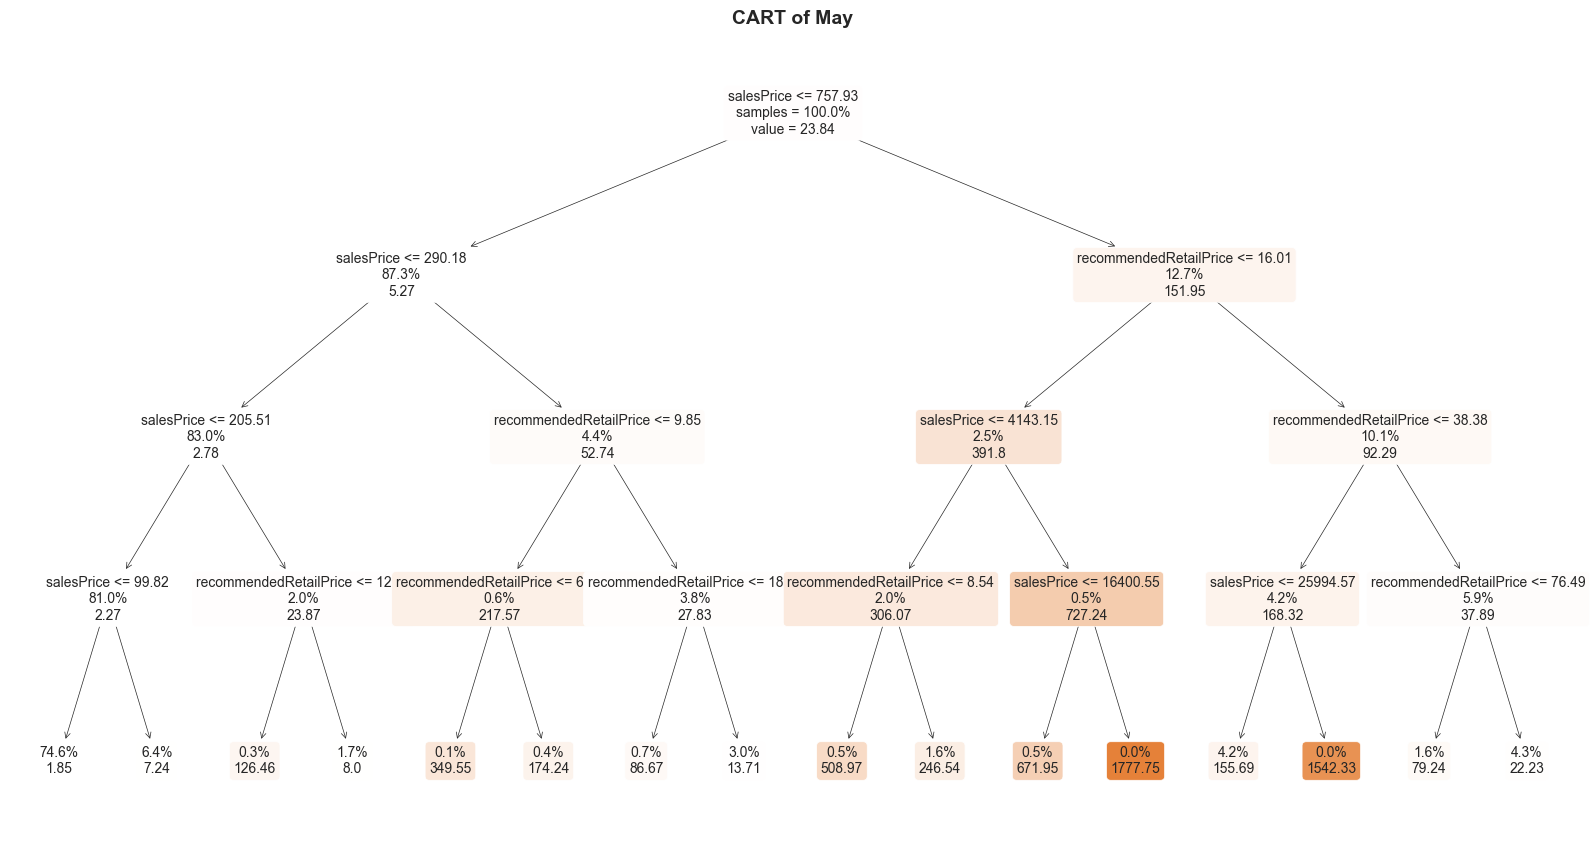

In [98]:
plt.figure(figsize=(18, 10))  # Adjust the figsize as needed

# Call plot_tree with appropriate parameters
plot_tree(Tree_reg_May, feature_names=x_May.columns, filled=True, fontsize=10, rounded=True,
          label='root', impurity=False, precision=2, class_names=True,
          proportion=True)

# Customize the text labels for better readability
text_settings = {'fontsize': 10, 'color': 'black', 'alpha': 1.0, 'ha': 'center', 'va': 'center', 'weight': 'bold'}
fontdict = {'fontsize': 12, 'fontweight': 'bold'}

plt.title("CART of May", fontsize=14, fontweight='bold')
plt.xlabel("Feature", fontsize=12)
plt.ylabel("Target", fontsize=12)

plt.show()

In [85]:
# sklearn regression module
y_pred_tree_May = Tree_reg_May.predict(df_X_May_test)

# Evaluation
#from sklearn.metrics import mean_squared_error
rmse_tree_May = mean_squared_error(y_pred_tree_May, df_Y_May_test, squared=False)

# R_square
R_square_tree_May= Tree_reg_May.score(df_X_May_test,df_Y_May_test)


#Mean absolute error
mean_absolute_error_tree_May= mean_absolute_error(df_Y_May_test, y_pred_tree_May)

print('The root mean square error (RMSE) is: ', rmse_tree_May)
print('R^2 obtained is:', R_square_tree_May)
print('Mean absolute error obtained is:', mean_absolute_error_tree_May)


The root mean square error (RMSE) is:  66.90781061057741
R^2 obtained is: 0.5480245237719022
Mean absolute error obtained is: 13.097754736176773


#  June Decision Tree Regression

In [99]:
Tree_reg_Jun= DecisionTreeRegressor(max_depth=4, min_samples_split= 5, random_state=42)

In [100]:
Tree_reg_Jun.fit(df_X_Jun_train,df_Y_Jun_train);

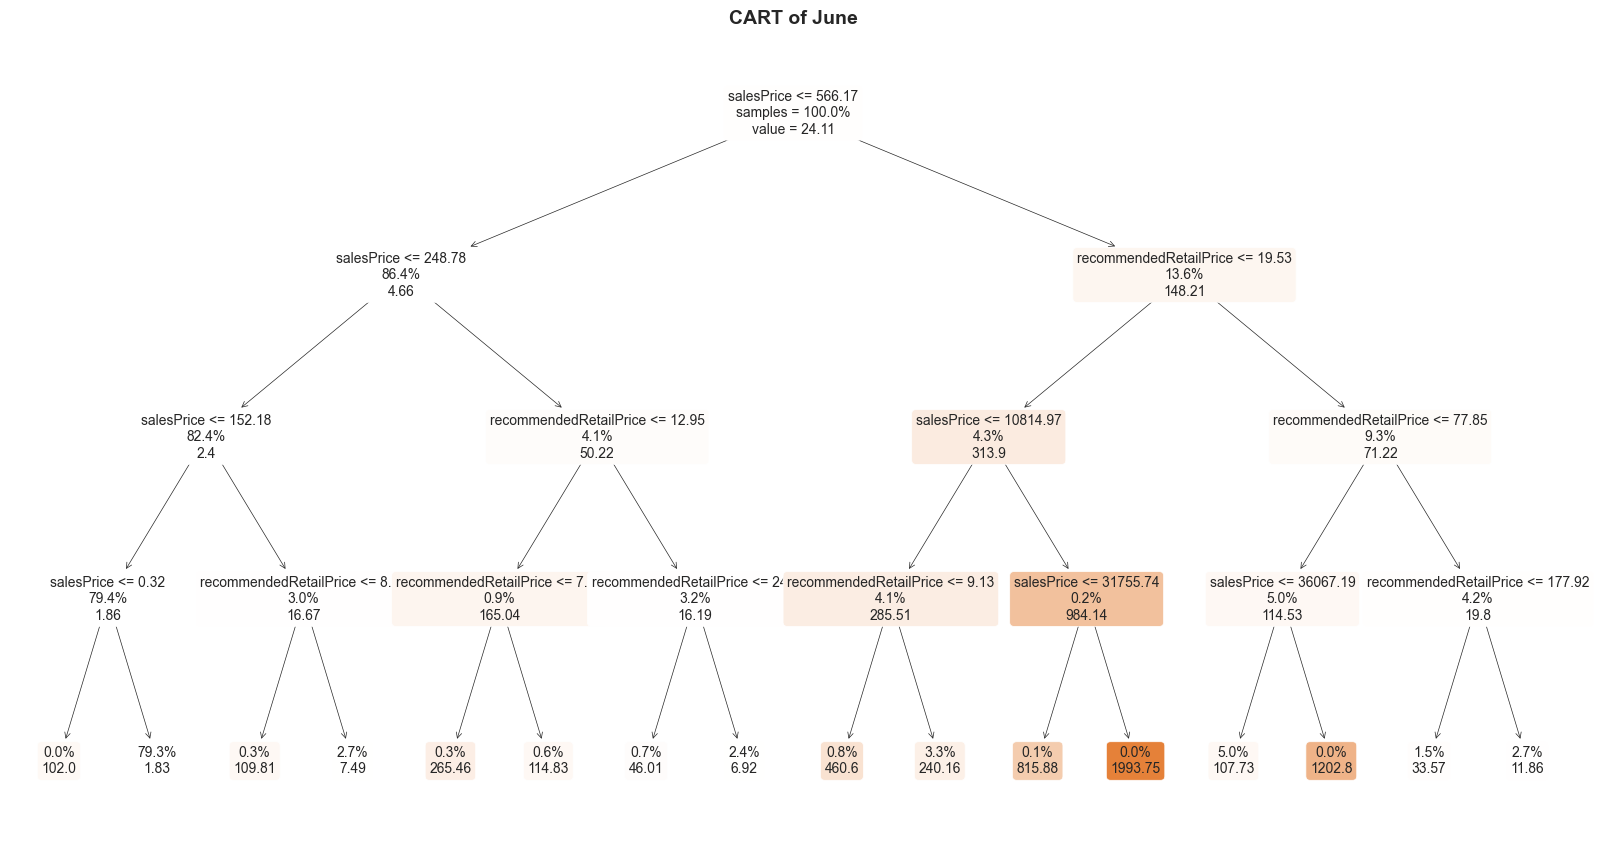

In [101]:
plt.figure(figsize=(18, 10))  # Adjust the figsize as needed

# Call plot_tree with appropriate parameters
plot_tree(Tree_reg_Jun, feature_names=x_Jun.columns, filled=True, fontsize=10, rounded=True,
          label='root', impurity=False, precision=2, class_names=True,
          proportion=True)

# Customize the text labels for better readability
text_settings = {'fontsize': 10, 'color': 'black', 'alpha': 1.0, 'ha': 'center', 'va': 'center', 'weight': 'bold'}
fontdict = {'fontsize': 12, 'fontweight': 'bold'}

plt.title("CART of June", fontsize=14, fontweight='bold')
plt.xlabel("Feature", fontsize=12)
plt.ylabel("Target", fontsize=12)

plt.show()

In [88]:
# sklearn regression module
y_pred_tree_Jun = Tree_reg_Jun.predict(df_X_Jun_test)

# Evaluation
#from sklearn.metrics import mean_squared_error
rmse_tree_Jun = mean_squared_error(y_pred_tree_Jun, df_Y_Jun_test, squared=False)

# R_square
R_square_tree_Jun= Tree_reg_Jun.score(df_X_Jun_test,df_Y_Jun_test)


#Mean absolute error
mean_absolute_error_tree_Jun= mean_absolute_error(df_Y_Jun_test, y_pred_tree_Jun)

print('The root mean square error (RMSE) is: ', rmse_tree_Jun)
print('R^2 obtained is:', R_square_tree_Jun)
print('Mean absolute error obtained is:', mean_absolute_error_tree_Jun)


The root mean square error (RMSE) is:  61.55154486131612
R^2 obtained is: 0.6431467911713252
Mean absolute error obtained is: 14.037796995423959


# Evaluating The Decision Tree Regression for the six months

In [89]:
# we will get the mean of every evaluation criteria over the 6 months

mean_rmse_tree=statistics.mean([
rmse_tree_Jan,rmse_tree_Feb, rmse_tree_Mar, rmse_tree_Apr, rmse_tree_May, rmse_tree_Jun])
mean_R_square_tree=statistics.mean([R_square_tree_Jan, R_square_tree_Feb, R_square_tree_Mar, R_square_tree_Apr, R_square_tree_May, R_square_tree_Jun])
mean_mean_absolute_error_tree=statistics.mean([mean_absolute_error_tree_Jan, mean_absolute_error_tree_Feb, mean_absolute_error_tree_Mar,mean_absolute_error_tree_Apr, mean_absolute_error_tree_May, mean_absolute_error_tree_Jun])

print("Mean of root mean square error (RMSE) for 6 months for decision tree  regression model is ", mean_rmse_tree)
print("Mean of R^2 obtained for 6 months for decision tree regression model is ", mean_R_square_tree)
print("Mean of Mean absolute error obtained for 6 months for decision tree regression model is ", mean_mean_absolute_error_tree)

Mean of root mean square error (RMSE) for 6 months for decision tree  regression model is  71.38452359497407
Mean of R^2 obtained for 6 months for decision tree regression model is  0.6075767371346957
Mean of Mean absolute error obtained for 6 months for decision tree regression model is  16.137526706996443
